# Projet 2 : Analysez des données de systèmes éducatifs

Vous êtes Data Scientist dans une start-up de la EdTech, nommée academy, qui propose des contenus de formation en ligne pour un public de niveau lycée et université.

Votre entreprise EdTech
Mark, votre manager, vous a convié à une réunion pour vous présenter le projet d’expansion à l’international de l’entreprise. Il vous confie une première mission d’analyse exploratoire, pour déterminer si les données sur l’éducation de la banque mondiale permettent d’informer le projet d’expansion.

Voici les différentes questions que Mark aimerait explorer, que vous avez notées durant la réunion :

- Quels sont les pays avec un fort potentiel de clients pour nos services ?
- Pour chacun de ces pays, quelle sera l’évolution de ce potentiel de clients ?
- Dans quels pays l'entreprise doit-elle opérer en priorité ?

## Votre mission
Mark vous a donc demandé de réaliser une analyse pré-exploratoire de ce jeu de données. Il vous a transmis cet email à la suite de la réunion :

Hello, Les données de la Banque mondiale sont disponibles à l’adresse suivante : https://datacatalog.worldbank.org/dataset/education-statistics
Ou en téléchargement direct à ce lien. Je te laisse regarder la page d’accueil qui décrit le jeu de données. En résumé, l’organisme “EdStats All Indicator Query” de la Banque mondiale répertorie 4000 indicateurs internationaux décrivant l’accès à l’éducation, l’obtention de diplômes et des informations relatives aux professeurs, aux dépenses liées à l’éducation... 
Tu trouveras plus d’info sur ce site : http://datatopics.worldbank.org/education/

Pour la pré-analyse, pourrais-tu :

1. Valider la qualité de ce jeu de données (comporte-t-il beaucoup de données manquantes, dupliquées ?)
2. Décrire les informations contenues dans le jeu de données (nombre de colonnes ? nombre de lignes ?)
3. Sélectionner les informations qui semblent pertinentes pour répondre à la problématique (quelles sont les colonnes contenant des informations qui peuvent être utiles pour répondre à la problématique de l’entreprise ?)
4. Déterminer des ordres de grandeurs des indicateurs statistiques classiques pour les différentes zones géographiques et pays du monde (moyenne/médiane/écart-type par pays et par continent ou bloc géographique)

Ton travail va nous permettre de déterminer si ce jeu de données peut informer les décisions d'ouverture vers de nouveaux pays. On va partager ton analyse avec le board, alors merci de soigner la présentation et de l'illustrer avec des graphiques pertinents et lisibles !

Pour préparer ce projet, la première étape est de préparer l'environnement de travail. Pour cela, on commence par importer toutes les librairies nécéssaires pour pouvoir avancer confortablement dans le projet. 

### Importation de toutes les librairies nécessaires

In [1]:
import pandas as pd
import numpy as np
import collections
import inspect
import missingno as msno
# pour la visualisation des graphes 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# pour se débarrasser de tous les warnings
import warnings
# pour manipuler les strings
import re
warnings.filterwarnings('ignore')

%matplotlib inline

### Importation de toutes les bases de données nécessaires

In [2]:
country = pd.read_csv('data/EdStatsCountry.csv')
countryseries = pd.read_csv('data/EdStatsCountry-Series.csv')
data = pd.read_csv('data/EdStatsData.csv', )
footnote = pd.read_csv('data/EdStatsFootNote.csv')
series = pd.read_csv('data/EdStatsSeries.csv')

In [3]:
# En cas d'erreur lors des modifications, un deuxième set du jeu de données est crée (version originale à conserver)
ocountry = country.copy()
ocountryseries = countryseries.copy()
odata = data.copy()
ofootnote = footnote.copy()
oseries = series.copy()

### Fonctions utiles pour la pré-analyse

In [4]:
# Création d'une fonction qui donne le pourcentage de données manquantes par colonne
def missing(df):
    x = df.columns.tolist() 
    y = round(df.isna().mean()*100, 2).tolist()
    df = pd.DataFrame({'Nom de la colonne' : x, 'Pourcentage de valeurs manquantes' : y})
    return df

In [5]:
# Création d'une fonction permettant de bien jongler la taille d'un ou des plots. 
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [6]:
# Renommage du nom des colonnes pour retirer tous les espaces et mettre tout en minuscule
def renaming_col(df):
    df.columns = df.columns.astype(str).str.lower()
    df.columns = df.columns.str.replace(' ','')
    #return df

## Première pré-Analyse

### Description et vérification de la validité de la qualité du jeu de données de façon superficielle

#### Pourcentage total de données manquantes, nombre de colonnes et de lignes du jeu de données dans sa totalité

In [7]:
# Description générale du jeu de données contenant cinq tables - Data, Country, CountrySeries, Footnote et Series
lst = [
    ['Data', round(data.isna().mean().mean()*100,2), data.duplicated(keep=False).sum(), data.shape[1], data.shape[0]], 
    ['Country', round(country.isna().mean().mean()*100,2), country.duplicated(keep=False).sum(), country.shape[1], country.shape[0]],
    ['CountrySeries', round(countryseries.isna().mean().mean()*100,2), countryseries.duplicated(keep=False).sum(), countryseries.shape[1], countryseries.shape[0]], 
    ['Series', round(series.isna().mean().mean()*100,2), series.duplicated(keep=False).sum(), series.shape[1], series.shape[0]], 
    ['Footnote', round(footnote.isna().mean().mean()*100,2), footnote.duplicated(keep=False).sum(), footnote.shape[1], footnote.shape[0]]
] 

df_missing = pd.DataFrame(lst, columns =['Nom de la table', 'Pourcentage total de données manquantes', 'Données dupliquées superficiellement', 'Nombre de colonnes', 'Nombre de lignes'], dtype = float)
df_missing

,Nom de la table,Pourcentage total de données manquantes,Données dupliquées superficiellement,Nombre de colonnes,Nombre de lignes
0,Data,86.10,0.0,70.0,886930.0
1,Country,30.52,0.0,32.0,241.0
2,CountrySeries,25.00,0.0,4.0,613.0
3,Series,71.72,0.0,21.0,3665.0
4,Footnote,20.00,0.0,5.0,643638.0


Conclusion de cette première analyse superficielle:
Il y a dans la base de données `country` 32 colonnes et 241 lignes.
Il y a dans la base de données `series` 21 colonnes et 3665 lignes.
Il y a dans la base de données `countryseries` 4 colonnes et 613 lignes.
Il y a dans la base de données `footnote` 5 colonnes et 643638 lignes.
Il y a dans la base de données `data` 70 colonnes et 886930 lignes.

Il manque énormément de données dans notre jeu de données et quelque soit les tables. Ainsi, dans la table data, il manque 86.1% des données. Beaucoup de tri devra être fait avant de pouvoir utiliser ces différents tables. 

Il n'y a pas de données répliquées dans la table `data`.

#### Pourcentage des données manquantes par table

In [8]:
# Pourcentage de valeurs manquantes dans la table `data`
miss_d = missing(data)
miss_d

,Nom de la colonne,Pourcentage de valeurs manquantes
0,Country Name,0.00
1,Country Code,0.00
2,Indicator Name,0.00
3,Indicator Code,0.00
4,1970,91.85
...,...,...
65,2085,94.20
66,2090,94.20
67,2095,94.20
68,2100,94.20


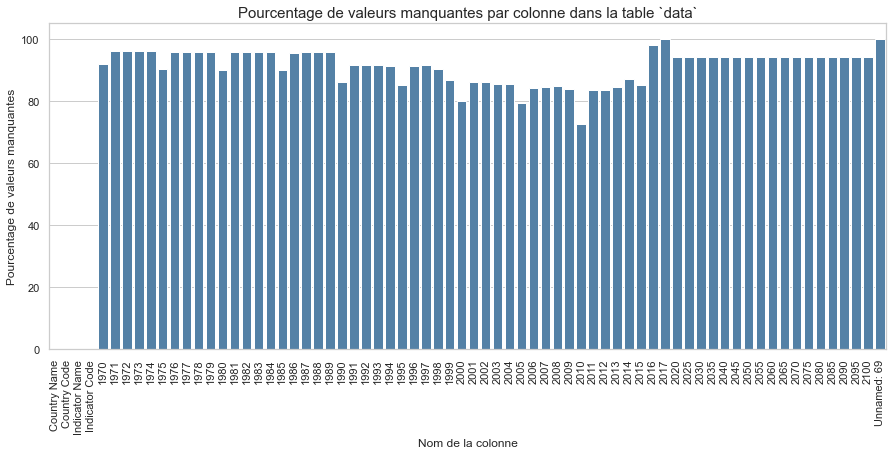

In [9]:
# Visualisation du nombre de valeurs manquantes par colonne pour la table `data`
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 6))

g = sns.barplot(
    x='Nom de la colonne', 
    y='Pourcentage de valeurs manquantes', 
    data=miss_d, 
    color ="steelblue")

g.set_title('Pourcentage de valeurs manquantes par colonne dans la table `data`', fontsize=15)

hide_text = g.set_xticklabels(g.get_xticklabels(), rotation=90)

Quatre colonnes de la table `data` ont toutes leurs valeurs. Ces dernières sont les suivantes: Country Name, Country Code, Indicator Name et Indicator Code.
La colonne "Unnamed:69" n'a aucune donnée. Ne correspondant a aucune variable et n'ayant aucune donnée, elle sera donc par la suite supprimée. 

Les seules colonnes où nous ne trouvons aucunes valeurs manquantes sont les colonnes correspondants à la description des données tels que le nom du pays, les indicateurs et leurs codes respectifs. Sinon, l'année avec le moins de valeurs manquantes est l'année 2010 avec 72.67%. Les années 2016 et 2017 sont au contraire les années avec le plus de données manquantes avec des valeurs avoisinant les 98 - 99 %. Seule une colonne est complètement vide - Unnamed 69. Nous allons donc nous en débarrasser par la suite. 

Dans notre étude, nous cherchons à déterminer qui seront nos futurs potentiels clients. Nous cherchons à monter une startup qui propose "des contenus de formation en ligne pour un public de niveau lycée et université". Ainsi, nous cherchons un public ayant entre 15-30 ans. Aujourd'hui, cette tranche d'âge concerne les personnes qui sont nées entre 1990 et 2005. De plus, proposant tout en ligne, il faudra considérer aussi l'impact d'internet depuis ces débuts (début 90). C'est pourquoi, il serait intéressant pour nous de supprimer les données avant les années 90. 

Sinon, nous pouvons aussi voir que les années de projection (années entre 2020 et 2100) contiennent elles aussi peu d'informations. Dans notre scénario, nous nous plaçons dans l'idée de monter une startup et de la voir bien évoluer à moyen/long terme, soit entre 5 à 15 ans. Ce qui nous donne une marge de manoeuvre jusqu'en 2035. Nous allons supprimer les données après 2035 pour des raisons évidentes;  Plus la projection se fait loin dans le temps et plus les biais deviennent importants. 

Pour pouvoir bien utiliser ces valeurs qui se trouvent dans les années de projection, il faudrait prendre le temps de connaître comment ces dernières ont été calculées. Or, pour une question de manque de temps, nous allons considérer ces données comme fiables. 

Mais nous ferons toute cette opération ces suppressions dans la partie nettoyage de notre rapport. 

In [10]:
# Pourcentage de valeurs manquantes dans la table `countryseries`
miss_cs = missing(countryseries)
miss_cs

,Nom de la colonne,Pourcentage de valeurs manquantes
0,CountryCode,0.0
1,SeriesCode,0.0
2,DESCRIPTION,0.0
3,Unnamed: 3,100.0


La table `countrySeries` contient trois colonnes (CountryCode, SeriesCode et DESCRIPTION) qui sont totalement renseignées. Seule la dernière (Unnamed: 3) ne l'est pas. C'est le même scénario que pour la table `data` et elle sera par conséquent aussi supprimée. 

In [11]:
# Pourcentage de valeurs manquantes dans la table `country`
miss_c = missing(country)
miss_c

,Nom de la colonne,Pourcentage de valeurs manquantes
0,Country Code,0.00
1,Short Name,0.00
2,Table Name,0.00
3,Long Name,0.00
4,2-alpha code,1.24
5,Currency Unit,10.79
6,Special Notes,39.83
7,Region,11.20
8,Income Group,11.20
9,WB-2 code,0.41


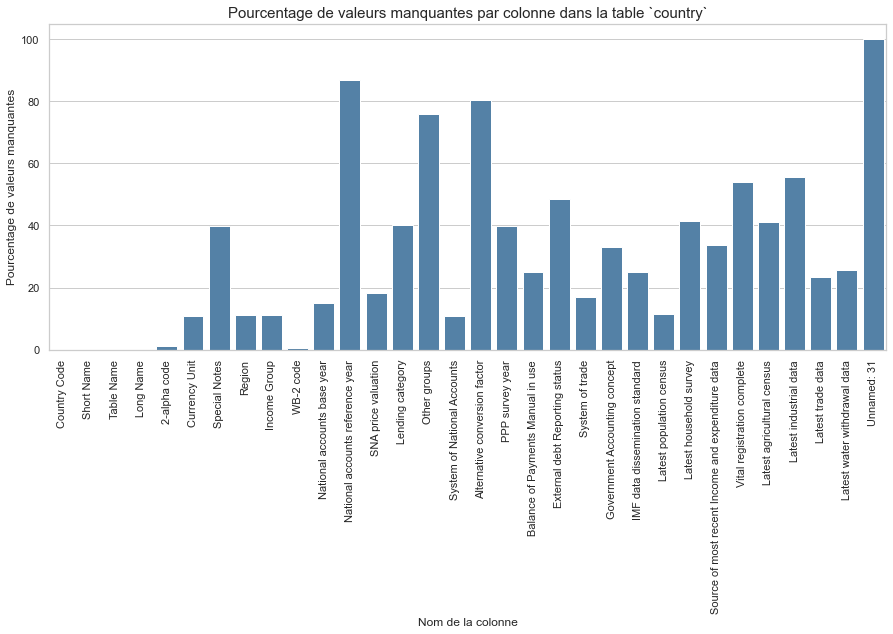

In [12]:
# Visualisation du nombre de valeurs manquantes par colonne pour la table `country`
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 6))

g = sns.barplot(
    x='Nom de la colonne', 
    y='Pourcentage de valeurs manquantes', 
    data=miss_c, 
    color ="steelblue")

g.set_title('Pourcentage de valeurs manquantes par colonne dans la table `country`', fontsize=15)

hide_text = g.set_xticklabels(g.get_xticklabels(), rotation=90)

La table `country` contient quatre colonnes (CountryCode, Short Name, Table Name et Long Name) qui sont totalement renseignées. Seule la dernière (Unnamed: 31) ne l'est pas. C'est le même scénario que pour la table `data` et elle sera par conséquent aussi supprimée. 

In [13]:
# Pourcentage de valeurs manquantes dans la table `series`
miss_s = missing(series)
miss_s 

,Nom de la colonne,Pourcentage de valeurs manquantes
0,Series Code,0.00
1,Topic,0.00
2,Indicator Name,0.00
3,Short definition,41.17
4,Long definition,0.00
5,Unit of measure,100.00
6,Periodicity,97.30
7,Base Period,91.43
8,Other notes,84.94
9,Aggregation method,98.72


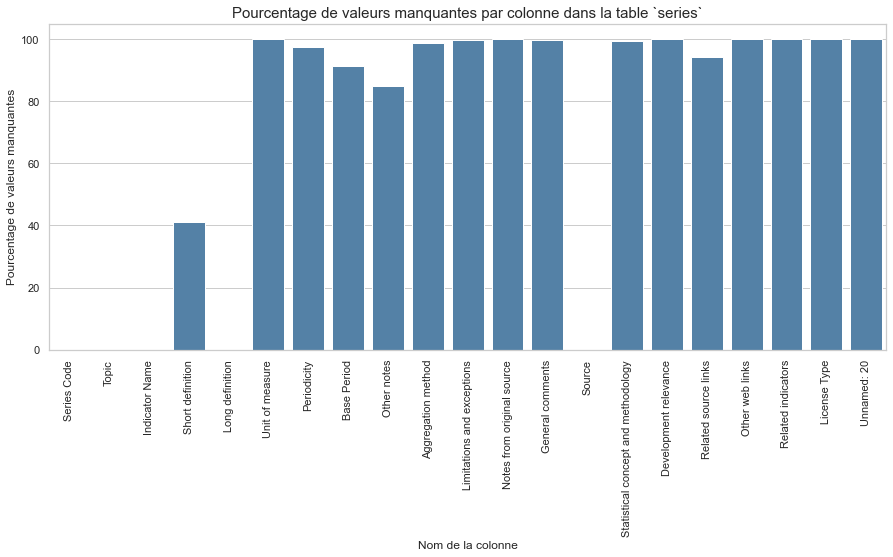

In [14]:
# Visualisation du nombre de valeurs manquantes par colonne pour la table `series`
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 6))

g = sns.barplot(
    x='Nom de la colonne', 
    y='Pourcentage de valeurs manquantes', 
    data=miss_s, 
    color ="steelblue")

g.set_title('Pourcentage de valeurs manquantes par colonne dans la table `series`', fontsize=15)

hide_text = g.set_xticklabels(g.get_xticklabels(), rotation=90)

La table `country` contient cinq colonnes (Series Code, Topic, Indicator Name, Long definition et source) qui sont totalement renseignées. Six colonnes, au contraire, sont totalement vides (Notes from original source, License Type, Unit of measure, Other web links, Related indicators, Unnamed: 20). Elles seront donc supprimées. 

In [15]:
# Pourcentage de valeurs manquantes dans la table `foonote`
miss_f = missing(footnote)
miss_f 

,Nom de la colonne,Pourcentage de valeurs manquantes
0,CountryCode,0.0
1,SeriesCode,0.0
2,Year,0.0
3,DESCRIPTION,0.0
4,Unnamed: 4,100.0


La table `footnote` contient quatre colonnes (CountryCode, SeriesCode, Year et DESCRIPTION) qui sont totalement renseignées. Seule la dernière (Unnamed: 4) ne l'est pas. C'est le même scénario que pour la table `data` et elle sera donc supprimée. 

## Premier nettoyage des tables

In [16]:
# Suppression des colonnes inutiles (complètement vides et donc inutilisables)
del data['Unnamed: 69']
del footnote['Unnamed: 4']
del country['Unnamed: 31']
del countryseries['Unnamed: 3']
series = series.drop(['Unnamed: 20', 'Related indicators', 'Other web links', 'Unit of measure', 'License Type', 'Notes from original source'], axis=1)

In [17]:
# Vérification que les colonnes vides ont bien été supprimées
print(country.columns.tolist());
print(countryseries.columns.tolist());
print(series.columns.tolist());
print(footnote.columns.tolist());
print(data.columns.tolist())

['Country Code', 'Short Name', 'Table Name', 'Long Name', '2-alpha code', 'Currency Unit', 'Special Notes', 'Region', 'Income Group', 'WB-2 code', 'National accounts base year', 'National accounts reference year', 'SNA price valuation', 'Lending category', 'Other groups', 'System of National Accounts', 'Alternative conversion factor', 'PPP survey year', 'Balance of Payments Manual in use', 'External debt Reporting status', 'System of trade', 'Government Accounting concept', 'IMF data dissemination standard', 'Latest population census', 'Latest household survey', 'Source of most recent Income and expenditure data', 'Vital registration complete', 'Latest agricultural census', 'Latest industrial data', 'Latest trade data', 'Latest water withdrawal data']
['CountryCode', 'SeriesCode', 'DESCRIPTION']
['Series Code', 'Topic', 'Indicator Name', 'Short definition', 'Long definition', 'Periodicity', 'Base Period', 'Other notes', 'Aggregation method', 'Limitations and exceptions', 'General comme

Comme constaté lors de la vérification des données manquantes, des colonnes qui portent le même nom dans des tables différentes ont été repérées. 

## Deuxième pré-analyse - description et vérification de la validité de la qualité des tables

### Noms des colonnes 

In [18]:
# Montrer toutes les colonnes des bases de données
print(country.columns.to_list());
print(countryseries.columns);
print(series.columns);
print(footnote.columns);
print(data.columns)

['Country Code', 'Short Name', 'Table Name', 'Long Name', '2-alpha code', 'Currency Unit', 'Special Notes', 'Region', 'Income Group', 'WB-2 code', 'National accounts base year', 'National accounts reference year', 'SNA price valuation', 'Lending category', 'Other groups', 'System of National Accounts', 'Alternative conversion factor', 'PPP survey year', 'Balance of Payments Manual in use', 'External debt Reporting status', 'System of trade', 'Government Accounting concept', 'IMF data dissemination standard', 'Latest population census', 'Latest household survey', 'Source of most recent Income and expenditure data', 'Vital registration complete', 'Latest agricultural census', 'Latest industrial data', 'Latest trade data', 'Latest water withdrawal data']
Index(['CountryCode', 'SeriesCode', 'DESCRIPTION'], dtype='object')
Index(['Series Code', 'Topic', 'Indicator Name', 'Short definition',
       'Long definition', 'Periodicity', 'Base Period', 'Other notes',
       'Aggregation method', '

Dans la table country, les seules variables qui nous intéressent sont les suivantes: 
Country Code, Short Name, Table Name, Long Name, Region et Income Group. 
La table country nous donne les informations nécessaires pour comprendre les pays et leurs descriptions/indicateurs respectifs.

Dans la table CountrySeries, les seules variables qui nous intéressent sont les suivantes:
Country Code, Series Code (qui fait référence aux indicateurs) et Description
La table countrySeries fait le lien entre la table country et la table Series. 

Dans la tables Series, les seules variables qui nous intéressent sont les suivantes:
Series Code, Indicator Name, Short definition, et à la rigueur Related Indicators.
La table Series nous donne les informations nécessaires par indicateurs. 

Dans la table footNote, nous retrouvons plus ou moins les mêmes informations que dans CountrySeries avec en plus des informations sur les années. Nous n'allons donc pas l'utiliser lors de la partie où nous fusionnons plusieurs tables en une seule table.

Dans la table data, toutes les variables nous intéressent à l'exception de Unnamed: 4. Nous ne pouvons pas utiliser une variable dont nous ne connaissons rien. 

### Vérification des colonnes communes entre tables

Pour vérifier s'il y a des colonnes communes, il est toujours intéressant de s'assurer qu'ils aient le même type d'enchaînement; ainsi, pour simplifier, nous allons retirer les espaces et tout mettre en minuscule.

In [19]:
# Renommage du nom des colonnes de toutes les tables 
renaming_col(data);
renaming_col(country);
renaming_col(countryseries);
renaming_col(series);
renaming_col(footnote);

In [20]:
# Variables communes entres les bases de données (BDs)
... print(np.intersect1d(data.columns, country.columns))
... print(np.intersect1d(data.columns, series.columns))
... print(np.intersect1d(data.columns, footnote.columns))
... print(np.intersect1d(data.columns, countryseries.columns))
... print(np.intersect1d(country.columns, countryseries.columns))
# Une variable en commun entre data et country : Country Code
# Une variable en commun entre data et series : Indicator Name
# Aucun nom en commun 
# (mais en réalité, il y a bien des variables en commun mais elles ne portent pas forcément exactement le même nom)

['countrycode']
['indicatorname']
['countrycode']
['countrycode']
['countrycode']


Une variable en commun entre data et country : Country Code et une variable en commun entre data et series : Indicator Name. Par contre, pour les autres tables, il n'y a aucun nom en commun, du moins en apparence. En réalité, il y a bien des variables en commun mais elles ne portent pas forcément exactement le même nom comme data.countryname et country.shortname.

In [21]:
footnote.tail()

,countrycode,seriescode,year,description
643633,ZWE,SH.DYN.MORT,YR2007,Uncertainty bound is 91.6 - 109.3
643634,ZWE,SH.DYN.MORT,YR2014,Uncertainty bound is 54.3 - 76
643635,ZWE,SH.DYN.MORT,YR2015,Uncertainty bound is 48.3 - 73.3
643636,ZWE,SH.DYN.MORT,YR2017,5-year average value between 0s and 5s
643637,ZWE,SP.POP.GROW,YR2017,5-year average value between 0s and 5s


In [22]:
country.tail() 

,countrycode,shortname,tablename,longname,2-alphacode,currencyunit,specialnotes,region,incomegroup,wb-2code,...,governmentaccountingconcept,imfdatadisseminationstandard,latestpopulationcensus,latesthouseholdsurvey,sourceofmostrecentincomeandexpendituredata,vitalregistrationcomplete,latestagriculturalcensus,latestindustrialdata,latesttradedata,latestwaterwithdrawaldata
236,XKX,Kosovo,Kosovo,Republic of Kosovo,NaN,Euro,"Kosovo became a World Bank member on June 29, ...",Europe & Central Asia,Lower middle income,KV,...,NaN,General Data Dissemination System (GDDS),2011,NaN,"Integrated household survey (IHS), 2011",NaN,NaN,NaN,NaN,NaN
237,YEM,Yemen,"Yemen, Rep.",Republic of Yemen,YE,Yemeni rial,Based on official government statistics and In...,Middle East & North Africa,Lower middle income,RY,...,Budgetary central government,General Data Dissemination System (GDDS),2004,"Demographic and Health Survey (DHS), 2013","Expenditure survey/budget survey (ES/BS), 2005",NaN,NaN,2006.0,2012.0,2005
238,ZAF,South Africa,South Africa,Republic of South Africa,ZA,South African rand,Fiscal year end: March 31; reporting period fo...,Sub-Saharan Africa,Upper middle income,ZA,...,Consolidated central government,Special Data Dissemination Standard (SDDS),2011,"Demographic and Health Survey (DHS), 2003; Wor...","Expenditure survey/budget survey (ES/BS), 2010",NaN,2007,2010.0,2012.0,2000
239,ZMB,Zambia,Zambia,Republic of Zambia,ZM,New Zambian kwacha,National accounts data have rebased to reflect...,Sub-Saharan Africa,Lower middle income,ZM,...,Budgetary central government,General Data Dissemination System (GDDS),2010,"Demographic and Health Survey (DHS), 2013","Integrated household survey (IHS), 2010",NaN,2010. Population and Housing Census.,NaN,2011.0,2002
240,ZWE,Zimbabwe,Zimbabwe,Republic of Zimbabwe,ZW,U.S. dollar,Fiscal year end: June 30; reporting period for...,Sub-Saharan Africa,Low income,ZW,...,Consolidated central government,General Data Dissemination System (GDDS),2012,"Demographic and Health Survey (DHS), 2010/11","Integrated household survey (IHS), 2011/12",NaN,NaN,NaN,2012.0,2002


In [23]:
series.tail() 

,seriescode,topic,indicatorname,shortdefinition,longdefinition,periodicity,baseperiod,othernotes,aggregationmethod,limitationsandexceptions,generalcomments,source,statisticalconceptandmethodology,developmentrelevance,relatedsourcelinks
3660,UIS.XUNIT.USCONST.3.FSGOV,Expenditures,Government expenditure per upper secondary stu...,NaN,"Average total (current, capital and transfers)...",NaN,NaN,NaN,NaN,NaN,NaN,UNESCO Institute for Statistics,NaN,NaN,NaN
3661,UIS.XUNIT.USCONST.4.FSGOV,Expenditures,Government expenditure per post-secondary non-...,NaN,"Average total (current, capital and transfers)...",NaN,NaN,NaN,NaN,NaN,NaN,UNESCO Institute for Statistics,NaN,NaN,NaN
3662,UIS.XUNIT.USCONST.56.FSGOV,Expenditures,Government expenditure per tertiary student (c...,NaN,"Average total (current, capital and transfers)...",NaN,NaN,NaN,NaN,NaN,NaN,UNESCO Institute for Statistics,NaN,NaN,NaN
3663,XGDP.23.FSGOV.FDINSTADM.FFD,Expenditures,Government expenditure in secondary institutio...,"Total general (local, regional and central) go...","Total general (local, regional and central) go...",NaN,NaN,Secondary,NaN,NaN,NaN,UNESCO Institute for Statistics,NaN,NaN,NaN
3664,XGDP.56.FSGOV.FDINSTADM.FFD,Expenditures,Government expenditure in tertiary institution...,"Total general (local, regional and central) go...","Total general (local, regional and central) go...",NaN,NaN,Tertiary,NaN,NaN,NaN,UNESCO Institute for Statistics,NaN,NaN,NaN


In [24]:
countryseries.tail()

,countrycode,seriescode,description
608,ZAF,SP.POP.GROW,"Data sources : Statistics South Africa, United..."
609,ZMB,SP.POP.GROW,Data sources: United Nations World Population ...
610,ZMB,SP.POP.TOTL,Data sources : United Nations World Population...
611,ZWE,SP.POP.TOTL,Data sources : United Nations World Population...
612,ZWE,SP.POP.GROW,Data sources: United Nations World Population ...


### Préparation d'un dataframe intermédiaire contenant seulement les pays, leur code, leur région et leur niveau économique  à partir de la table  'country'

A partir des différentes informations recueillies sur la table `country`, nous nous rendons compte qu'elle contient exactement ce que nous recherchons pour avoir une notion du niveau de vie et de la zone géographique/continent d'un pays. Nous allons regrouper ces informations dans une seule table que nous nommerons `df`. Cette table nous sera utile lorsque nous souhaiterons connecter les pays de la table `data` aux informations récoltées dans la table `country`.

In [25]:
# Préparation d'un dataframe contenant que les informations liés aux pays
df = country[['shortname', 'countrycode', 'region','incomegroup']].drop_duplicates() 

# Renommage de la colonne shortname en country
df = df.rename(columns={'shortname': 'country'})

# D'après, cette table, il y a 241 pays différents.
df.shape

(241, 4)

In [26]:
print("Nous nous retrouvons à la fin avec", df.country.nunique(),"'pays'.\n\nCes pays se trouvent dans", df.region.nunique(),"régions qui sont les suivantes:\n", set(df.region.dropna()),".\n\nNous avons ", df.incomegroup.nunique(),"niveaux économiques qui sont les suivants:\n", set(df.region.dropna()))

Nous nous retrouvons à la fin avec 241 'pays'.

Ces pays se trouvent dans 7 régions qui sont les suivantes:
 {'Latin America & Caribbean', 'Europe & Central Asia', 'North America', 'Sub-Saharan Africa', 'East Asia & Pacific', 'Middle East & North Africa', 'South Asia'} .

Nous avons  5 niveaux économiques qui sont les suivants:
 {'Latin America & Caribbean', 'Europe & Central Asia', 'North America', 'Sub-Saharan Africa', 'East Asia & Pacific', 'Middle East & North Africa', 'South Asia'}


In [27]:
# Création de deux listes - liste des régions et liste du niveau économique
list_r = set(df.region.dropna());
list_ig = set(df.incomegroup.dropna());

### Description approfondie de la table `data`

Dans cette deuxième partie, nous allons passer un peu plus de temps à comprendre notre base de données principale, nommé `data`. Nous allons déjà prendre le temps de regarder le nom de ses colonnes. 

In [28]:
data.info(verbose = False, null_counts = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886930 entries, 0 to 886929
Columns: 69 entries, countryname to 2100
dtypes: float64(65), object(4)
memory usage: 466.9+ MB


In [29]:
data.describe()

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
count,7.228800e+04,3.553700e+04,3.561900e+04,3.554500e+04,3.573000e+04,8.730600e+04,3.748300e+04,3.757400e+04,3.757600e+04,3.680900e+04,...,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04
mean,1.974772e+09,4.253638e+09,4.592365e+09,5.105006e+09,5.401493e+09,2.314288e+09,5.731808e+09,6.124437e+09,6.671489e+09,7.436724e+09,...,7.145788e+02,7.224868e+02,7.271290e+02,7.283779e+02,7.266484e+02,7.228327e+02,7.176899e+02,7.113072e+02,7.034274e+02,6.940296e+02
std,1.211687e+11,1.804814e+11,1.914083e+11,2.059170e+11,2.112150e+11,1.375059e+11,2.215546e+11,2.325489e+11,2.473986e+11,2.660957e+11,...,2.136851e+04,2.215845e+04,2.287990e+04,2.352338e+04,2.408149e+04,2.455897e+04,2.496587e+04,2.530183e+04,2.556069e+04,2.574189e+04
min,-1.435564e+00,-1.594625e+00,-3.056522e+00,-4.032582e+00,-4.213563e+00,-3.658569e+00,-2.950945e+00,-3.174870e+00,-3.558749e+00,-2.973612e+00,...,-1.830000e+00,-1.630000e+00,-1.440000e+00,-1.260000e+00,-1.090000e+00,-9.200000e-01,-7.800000e-01,-6.500000e-01,-5.500000e-01,-4.500000e-01
25%,8.900000e-01,8.853210e+00,9.240920e+00,9.595200e+00,9.861595e+00,1.400000e+00,9.312615e+00,9.519913e+00,1.000000e+01,1.000000e+01,...,3.000000e-02,3.000000e-02,3.000000e-02,2.000000e-02,2.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02
50%,6.317724e+00,6.316240e+01,6.655139e+01,6.969595e+01,7.087760e+01,9.677420e+00,7.101590e+01,7.133326e+01,7.290512e+01,7.510173e+01,...,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.200000e-01
75%,6.251250e+01,5.655200e+04,5.863650e+04,6.202900e+04,6.383675e+04,7.854163e+01,5.682800e+04,5.739175e+04,5.940425e+04,6.411500e+04,...,7.500000e+00,7.505000e+00,7.500000e+00,7.300000e+00,7.100000e+00,6.722500e+00,6.080000e+00,5.462500e+00,4.680000e+00,4.032500e+00
max,1.903929e+13,1.986457e+13,2.100916e+13,2.238367e+13,2.282991e+13,2.300634e+13,2.424128e+13,2.521383e+13,2.622101e+13,2.730873e+13,...,2.813670e+06,2.951569e+06,3.070879e+06,3.169711e+06,3.246239e+06,3.301586e+06,3.337871e+06,3.354746e+06,3.351887e+06,3.330484e+06


La fonction 'Describe' fait ressortir les variables quantitatives dans la table `data`. Ces variables quantitatives sont toutes les colonnes correspondant aux années. Ce sont les colonnes entre 1970 et 2100. Elles correspondent aux années et aux projections.  

In [30]:
data.sample(5)

,countryname,countrycode,indicatorname,indicatorcode,1970,1971,1972,1973,1974,1975,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
489252,Latvia,LVA,PASEC: Distribution of 6th grade reading score...,LO.PASEC.REA.6.P50,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77690,Sub-Saharan Africa,SSF,EGRA: Correct Isolated Words Read Per Minute (...,LO.EGRA.CWPM.HAR.2GRD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
704323,Serbia,SRB,DHS: Typology of out-of-school children. Prima...,HH.DHS.OOST.DO.Q2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42207,Least developed countries: UN classification,LDC,Percentage of female teachers in post-secondar...,UIS.TRTP.4.F,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
474316,Kosovo,XKX,MICS: Average years of schooling by age group....,HH.MICS.YRS.1519.U,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
data.nunique()

countryname        242
countrycode        242
indicatorname     3665
indicatorcode     3665
1970             24595
                 ...  
2080              7466
2085              7335
2090              7150
2095              7044
2100              6914
Length: 69, dtype: int64

Avec nos différentes observations, nous pouvons constater plusieurs choses: 
  
  * il y a quatre variables qualitatives et 65 variables quantitatives 
  * les variables `countryname` et `countrycode` nous indiquent quels pays nous étudions (modes - qualitatif)
  * les variables `indicatorname` et `indicatorcode` font référence nous indiquent quels indicateurs nous étudions (modes - qualitatif)
  * toutes les autres variables, des données, font référence aux années (de `1970` à `2100`) où sont récupérées les observations temporelles (quantitatif), croisant entre l'année, l'indicateur et le pays.
  
Nous allons d'abord analyser et nettoyer séparément ces trois grands groupes avant de recouper de nouveaux les données dans la partie analyse. 

Nous pouvons considérer que nous avons à faire à trois types d'indicateurs différents:

    1. les indicateurs géographiques (modalités des colonnes `countryname` et `countrycode`)
    2. les indicateurs statistiques (modalités des colonnes `indicatorname` et `indicatorcode`)
    3. les indicateurs temporelles (colonnes `1970` à `2100`) - dont certains sont des descriptions et d'autres des projections

### Description des trois types d'indicateurs 

#### Description rapide des indicateurs géographiques

In [32]:
print(data.countryname.nunique());
print(data.countrycode.nunique());
print(set(data.countryname));

242
242
{'Low income', 'Kosovo', 'Bosnia and Herzegovina', 'Fiji', 'Turks and Caicos Islands', 'West Bank and Gaza', 'Namibia', 'Togo', 'New Zealand', 'South Africa', 'Burkina Faso', 'Djibouti', 'Micronesia, Fed. Sts.', 'Malta', 'Greece', 'New Caledonia', 'Hungary', 'East Asia & Pacific (excluding high income)', 'Vanuatu', 'South Sudan', 'Angola', 'Swaziland', 'Bolivia', 'Madagascar', 'Jordan', 'Botswana', 'Israel', 'Japan', 'Montenegro', 'Zambia', 'American Samoa', 'Estonia', 'Finland', 'Ukraine', 'Paraguay', 'Maldives', 'Mongolia', 'Virgin Islands (U.S.)', 'Luxembourg', 'Latvia', 'Nigeria', 'Korea, Dem. People’s Rep.', 'Morocco', 'Eritrea', 'Iraq', 'Tuvalu', 'Samoa', 'Guinea', 'High income', 'Euro area', 'Europe & Central Asia', 'Aruba', 'United States', 'Dominican Republic', 'Czech Republic', 'French Polynesia', 'Ireland', 'Macedonia, FYR', 'Oman', 'East Asia & Pacific', 'Tunisia', 'Guam', 'Middle East & North Africa', 'Middle income', 'St. Kitts and Nevis', 'Colombia', 'Romania', '

Il y a 242 pays différents selon la base de données `data`. Nous allons voir à quoi, ils correspondent. En regardant dans cette liste, nous nous rendons compte que nous n'avons pas que des pays dans cette liste, mais aussi des zones géographiques, des zones monétaires/géographiques voire même des îles appartenants à des pays. Il faudra se débarrasser des zones géographiques ne correspondant pas à un pays lors d'un premier nettoyage des pays à garder. 

#### Description rapides des indicateurs statistiques

In [33]:
print(data.indicatorname.nunique());
print(data.indicatorcode.nunique());

3665
3665


Il y a 3665 indicateurs statistiques dans la base de données `data`. Nous verrons davantage sur ces derniers dans la suite du projet.

Pour l'instant, nous savons que nous avons autant de noms d'indicateurs statistiques que de code d'indicateurs statistiques. Ce qui signifie qu'il n'y a pas d'incohérence au niveau du nombre de données au premier abord en ce qui concerne les indicateurs statistiques. 

#### Description rapides des indicateurs temporels

Les indicateurs temporels ne sont pas des modalités dans une colonnes mais des colonnes distinctes. Comme nous avons pu le voir dans la partie où nous nous intéressons aux colonnes et à quoi elles correspondent, nous avons vu que les quatre premières colonnes correspondaient à des variables qualitatives sans rapport avec les années. Nous allons donc les retirer pour le calcul du nombre d'années.

In [34]:
print(len(data.columns[4:]));
print(data.columns[4:]);

65
Index(['1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978',
       '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987',
       '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996',
       '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2020', '2025', '2030', '2035', '2040', '2045',
       '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090',
       '2095', '2100'],
      dtype='object')


Il y a 65 indicateurs temporels au total. De 1970 à 2017, nous avons des indicateurs temporels tous les ans. A partir de 2020, nous passons par des indicateurs temporels donnés tous les cinq ans. De plus ceci correspondent à des projections dans le temps. 

### Vérification d'observations manquantes

Par exemple, est-ce qu'il y a des pays, ayant des lignes liant année et indicateur statistiques, qui manquent ?  

In [35]:
data['total_Amount'] = data.groupby('countryname', sort=False)['indicatorname'].transform('count')
data[['countryname', 'total_Amount']].drop_duplicates().head(5)

# Filtre permettant de voir si toutes les années et tous les pays ont 3365 lignes (soit tous les indicateurs)
isnot_3665 = data[data.total_Amount != 3665]
isnot_3665.shape

(0, 70)

Il n'y a pas d'indicateurs statistiques manquants parce qu'il y aurait un pays manquant ou un indicateur oublié. 

## Nettoyage de la base de données `data` en vue de son utilisation pour la partie analyse

### Première suppression de certains 'pays' 

Pour nettoyer cela, nous allons vérifier si la liste des pays dans la table `df` qui est le raccourci de `country` ne contient lui que des pays.

In [36]:
df.country.nunique()
#set(df.country) #contient des 'pays' comme World, Arab World, Low income, etc. 

241

Ce n'est pas le cas, car cette deuxième liste en contient 241, soit juste un seul "pays" en moins. Nous allons alors utiliser une autre méthode. Nous allons créer deux autres listes, l'une contenant les 'regions' et l'autre contenant les 'income group'. Nous allons encore utiliser la table `df` pour créer ces listes. 

In [37]:
# Création d'une première liste de pays
list_c1 = data.countryname.drop_duplicates().to_list()
list_c1

['Arab World',
 'East Asia & Pacific',
 'East Asia & Pacific (excluding high income)',
 'Euro area',
 'Europe & Central Asia',
 'Europe & Central Asia (excluding high income)',
 'European Union',
 'Heavily indebted poor countries (HIPC)',
 'High income',
 'Latin America & Caribbean',
 'Latin America & Caribbean (excluding high income)',
 'Least developed countries: UN classification',
 'Low & middle income',
 'Low income',
 'Lower middle income',
 'Middle East & North Africa',
 'Middle East & North Africa (excluding high income)',
 'Middle income',
 'North America',
 'OECD members',
 'South Asia',
 'Sub-Saharan Africa',
 'Sub-Saharan Africa (excluding high income)',
 'Upper middle income',
 'World',
 'Afghanistan',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas, The',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Berm

Nous pouvons toujours observer des zones qui ne sont pas des pays comme 'Sub-Saharan Africa (all income levels)' et 'Sub-Saharan Africa (developing only)'. Nous allons alors appliquer une fonction qui va se débarasser des modalités qui ne sont pas des pays en retirant des mots qui font référence au PIB. 

In [38]:
# Création d'une fonction qui retire tous les zones contenant des mots trouvés dans la liste `wrongWords` 
wrongWords = ['World','OECD', 'income', '&', 'Union', 'HIPC', 'Least', 'area', 'North America', 'South Asia', 'Sub-Saharan Africa']
blacklist = re.compile('|'.join([re.escape(word) for word in wrongWords]))
blacklist

re.compile(r'World|OECD|income|\&|Union|HIPC|Least|area|North\ America|South\ Asia|Sub\-Saharan\ Africa',
re.UNICODE)

In [39]:
# Amélioration de la liste des pays pour qu'il n'y ait vraiment que des pays
list_c = [word for word in list_c1 if not blacklist.search(word)]
list_c

['Afghanistan',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas, The',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Channel Islands',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Curacao',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt, Arab Rep.',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Ethiopia',
 'Faroe Islands',
 'Fiji',
 'Finland',
 'France',
 'French Pol

In [40]:
# Vérification des pays faisant partie de `data` mais n'étant ni reliés à une région et/ou à un niveau économique
set(data.countryname[~data.countryname.isin(list_c)])
# On peut voir dans cette première liste de zones géographiques supprimées mais aussi des îles appartenant à des pays comme la France ou le Danemark. 

{'Arab World',
 'East Asia & Pacific',
 'East Asia & Pacific (excluding high income)',
 'Euro area',
 'Europe & Central Asia',
 'Europe & Central Asia (excluding high income)',
 'European Union',
 'Heavily indebted poor countries (HIPC)',
 'High income',
 'Latin America & Caribbean',
 'Latin America & Caribbean (excluding high income)',
 'Least developed countries: UN classification',
 'Low & middle income',
 'Low income',
 'Lower middle income',
 'Middle East & North Africa',
 'Middle East & North Africa (excluding high income)',
 'Middle income',
 'North America',
 'OECD members',
 'South Asia',
 'Sub-Saharan Africa',
 'Sub-Saharan Africa (excluding high income)',
 'Upper middle income',
 'World'}

In [41]:
# Suppression des pays ne se trouvant pas dans la liste list_c créée plus tôt
data = data[data.countryname.isin(list_c)];
# Vérification du nombre de pays restant dans `data` après la suppression 
print(data.countryname.nunique());
# Tous les pays que nous avons dans notre liste sont aussi dans la table `data`.

# Modification de la table df
# df[~df.countrycode.isin(set(data.countrycode))] # Toutes les lignes que nous voulions bien retirées le sont
df2= df[df.countrycode.isin(set(data.countrycode))]
print(df2.country.nunique());

set(data.countryname[~data.countrycode.isin(set(df2.countrycode))])

217
216


{'British Virgin Islands'}

the British Virgin Islands font parties de la Grande Bretagne. Dans cette première étude rapide, nous ne sommes pas forcéement intéressée à garder les territoires outre-mers de certains pays. Cela viendra dans un deuxième temps. Ainsi, nous pouvons nous en passer pour cette étude en considérant la Grande Bretagne dans sa globalité.

In [42]:
# Pourcentage de la base de données qui a été supprimée
round((odata.shape[0]-data.shape[0])/odata.shape[0]*100,2)

10.33

Un peu plus de 10% de la table `data` a été retirée, ce qui est énorme. Nous aurions pu garder ces modalités mais pour des raisons de temps, de practicité et parce que les questions demandées au début du projet se focalisaient sur les pays et non sur les zones, nous avons décidé de nous en débarasser. 

### Première suppression d'indicateurs statistiques (ayant 95% de valeurs manquantes)

#### Nombre total de valeurs manquantes dans la dataframe `data`

In [43]:
print("Il y a", data.isna().sum().sum(), 'valeurs nulles dans la table `data` sur', data.shape[0]*data.shape[1], ' valeurs, soit', round(data.isna().mean().mean()*100, 2), "% au total.")

Il y a 46900581 valeurs nulles dans la table `data` sur 55671350  valeurs, soit 84.25 % au total.


In [44]:
data.indicatorname.sample(10)

871140              Primary completion rate, both sexes (%)
772600    Survival rate to Grade 5 of primary education,...
172604    Barro-Lee: Percentage of female population age...
814567    EGRA: Oral Reading Fluency - Correct Words Rea...
187992    EGRA: Reading Comprehension - Share of student...
532828    LLECE: 6th grade students by mathematics profi...
643644    PISA: Female 15-year-olds by science proficien...
863003    PASEC: 6th grade students by mathematics profi...
626250    UIS: Percentage of population age 25+ with a c...
776279    Teachers in post-secondary non-tertiary educat...
Name: indicatorname, dtype: object

In [45]:
# Préparation d'une table en format long -- facilitation de certaines vérifications futures sur les données
data_m = data.drop(['indicatorcode','countryname','total_Amount'],axis=1)
column_list = data_m.columns.tolist()
id_vars_list = column_list[:2]

data_m = data_m.melt(id_vars=id_vars_list, var_name="year", value_name = "value")

In [46]:
# Fusion de dataframes - POUR LA PARTIE REFONTE DU DATAFRAME FINAL -- GARDE POUR PLUS TARD
data2 = data_m.merge(right = df2[['countrycode', 'country', 'region', 'incomegroup']], 
                  on='countrycode', how='left')

In [47]:
# Indicateurs avec que des valeurs nulles 
low_indicator = data_m.groupby('indicatorname').agg({'value': lambda x: x.isna().mean()}).sort_values(by = 'value').reset_index()
print("Après avoir s'être débarrassé d'une partie des données (en supprimant certaines zones géographiques),\nnous pouvons dire qu'il y a", low_indicator[(low_indicator['value']>=1)].shape[0], "indicateurs statistiques avec que des valeurs nulles.")

Après avoir s'être débarrassé d'une partie des données (en supprimant certaines zones géographiques),
nous pouvons dire qu'il y a 0 indicateurs statistiques avec que des valeurs nulles.


In [48]:
low_indicator = low_indicator[(low_indicator['value']>=.95)]
print("Cependant, il y a", low_indicator.shape[0],"indicateurs statistiques avec au moins 95% de leurs données qui manquent.")

Cependant, il y a 2006 indicateurs statistiques avec au moins 95% de leurs données qui manquent.


Nous retirerons ces indicateurs statistiques par la suite. Mais avant de faire cette opération, il faut se rappeler ce que nous avions vu précédemment; certaines années (les années avant 1990 et les années après 2015) contenaient très peu de données et pouvaient potentiellement plomber nos résultats dans la partie analyse. Ils vont donc être supprimer maintenant. 

### Première suppression des années allant de 1960 à 1990 et de 2016 à 2100

In [49]:
# Vérification des années ayant un pourcentage de données que nous considérons comme trop important pour être utilisables 
# (plus de 85% de données manquantes est ce qui a été choisi)
year = data_m.groupby('year').agg({'value': lambda x: x.isna().mean()}).sort_values(by = 'value')
year[(year['value']>=0.9)].sort_values(by = 'year')

,value
year,
1970,0.913768
1971,0.960125
1972,0.960230
1973,0.960478
1974,0.960284
1976,0.958241
1977,0.958151
1978,0.958156
1979,0.959173


Comme nous l'avons dit précédemment, pour notre analyse, nous nous intéressons aux personnes qui arrivent sur le marché aujourd'hui et demain. Ce sont principalement des gens autour de 15-25 ans (voire 30 ans si nous voulons être large). Ce qui signifie qu'ils sont nés au plus tôt dans les années 1990. 
Nous n'allons donc pas garder les années avant 1990 et comme nous l'avions déjà fait remarqué, nous ne cherchons pas monter une startup qui durera au moins 15 ans. Nous irons donc pas au-delà des années 2035. 

Notre table ci-dessus nous confortent aussi dans cette decision, car nous n'avons pas assez de données intéressantes durant cette période. Nous allons donc créer une liste comportant toutes ces années et supprimer de toutes les valeurs de ces années dans la table `data`.

In [50]:
# Avant de supprimer, il faut modifier le type de la variable "year" car ce dernier est un objet 
# et que pour bien faire la prochaine modification, nous avons besoin de les convertir en integer. 
data_m = data_m.astype({"year": int}) 

# Suppression des années avant 1990 et après 2035
data_m = data_m[(data_m['year']>=1990) & (data_m['year']<=2035)].sort_values(by = 'year')

# Vérification que les bonnes années ont été conservées
data_m.year.drop_duplicates().to_list()
# C'est bien le cas. 

[1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2020,
 2025,
 2030,
 2035]

In [51]:
# Vérification du pourcentage de valeurs manquantes dans la base de données en train d'être nettoyée
data_m.groupby('year').agg({'value': lambda x: x.isna().mean()}).sort_values(by = 'year')

,value
year,
1990,0.850265
1991,0.913196
1992,0.912136
1993,0.912039
1994,0.910341
1995,0.842687
1996,0.911308
1997,0.916453
1998,0.903370


### Deuxième suppression des indicateurs ayant trop de valeurs manquantes (>85%)

In [52]:
# Observations sur les 5 indicateurs ayant le pourcentage de valeurs nulles les moins élevées
data_m.groupby('indicatorname').agg({'value': lambda x: x.isna().mean()}).sort_values(by = 'value').head(5)

,value
indicatorname,
"Population, total",0.169211
Population growth (annual %),0.170075
Theoretical duration of primary education (years),0.198445
Official entrance age to primary education (years),0.198445
Theoretical duration of pre-primary education (years),0.205645


In [53]:
# Observations sur les 5 indicateurs ayant le pourcentage de valeurs nulles les plus élevées
data_m.groupby('indicatorname').agg({'value': lambda x: x.isna().mean()}).sort_values(by = 'value').tail(5)

,value
indicatorname,
EGRA: Reading Comprehension - Share of students scoring at least 80 percent (%). Dagaare. 2nd Grade,0.999856
EGRA: Reading Comprehension - Share of students scoring at least 80 percent (%). Cinyanja. 2nd Grade,0.999856
EGRA: Reading Comprehension - Share of students scoring at least 80 percent (%). Chitonga. 2nd Grade,0.999856
EGRA: Oral Reading Fluency - Share of students with a zero score (%). Nzema. 2nd Grade,0.999856
EGRA: Correct Non-Words Read Per Minute (Mean). Kinyarwanda. 6th Grade,0.999856


In [54]:
# Indicateurs avec 85% de valeurs étant nulles 
low_indicator2 = data_m.groupby('indicatorname').agg({'value': lambda x: x.isna().mean()}).sort_values(by = 'value').reset_index()
print("Après avoir s'être débarrassé d'une partie des données (en supprimant certaines zones géographiques),\nnous pouvons dire qu'il y a", low_indicator2[(low_indicator2['value']<=0.85)].shape[0], "indicateurs statistiques avec 85% de valeurs nulles.")

Après avoir s'être débarrassé d'une partie des données (en supprimant certaines zones géographiques),
nous pouvons dire qu'il y a 802 indicateurs statistiques avec 85% de valeurs nulles.


In [55]:
# Création d'une liste avec les indicateurs avec un pourcentage de données manquantes supérieure à 95%
ind_del = low_indicator2[(low_indicator2['value']>=0.85)].indicatorname.to_list()

In [56]:
# Suppression des indicateurs statistiques ayant moins de 15% de données qui ne manquent pas
data_m = data_m[~data_m.indicatorname.isin(ind_del)]
data_m.indicatorname.nunique()
# Il nous reste désormais 802 indicateurs statistiques sur les 3665 du début. Ce qui est déjà une bonne réduction.
# Pour des raisons de temps, nous allons regarder dans cette liste, plutôt que de continuer notre réduction de façon sommaire.

802

In [57]:
# Liste des indicateurs statistiques restant
#set(data_m.indicatorname)

Pour rappel, nous cherchons des clients entre 15-25 ans principalement. Il faut qu'Internet soit déjà bien ancré dans le paysage du pays. Il faut qu'il y ait assez de jeunes dans cette population (possiblement des 

In [58]:
# Création d'une fonction qui retire tous les mots qui font référence aux sexes des individus et à l'école primaire (hors de notre population cible)
# Ce sont des indicateurs intéressants mais qui ne vont pas faire partie de notre premier objectif qui est de percer dans les pays
wordsToAvoid = ['female', 'male', 'primary', 'Agriculture', 'Humanities', 'childhood', 'HIV', 'Grade ' ]
blacklist2 = re.compile('|'.join([re.escape(word) for word in wordsToAvoid]))

list_i = [word for word in set(data_m.indicatorname) if not blacklist2.search(word)]
list_i = sorted(list_i)
len(list_i)
# Nous avons 224 indicateurs statistiques qui nous restent. 

224

In [59]:
list_i

['Adjusted net enrolment rate, lower secondary, both sexes (%)',
 'Adjusted net enrolment rate, lower secondary, gender parity index (GPI)',
 'All staff compensation as % of total expenditure in public institutions (%)',
 'All staff compensation as % of total expenditure in secondary public institutions (%)',
 'Cumulative drop-out rate to the last grade of lower secondary general education, both sexes (%)',
 'Current expenditure as % of total expenditure in public institutions (%)',
 'Current expenditure as % of total expenditure in secondary public institutions (%)',
 'Current expenditure as % of total expenditure in tertiary public institutions (%)',
 'Duration of compulsory education (years)',
 'Enrolment in lower secondary education, both sexes (number)',
 'Enrolment in lower secondary education, private institutions, both sexes (number)',
 'Enrolment in lower secondary education, public institutions, both sexes (number)',
 'Enrolment in lower secondary general, both sexes (number)

D'après un article de l'OECD iLibrary logo titré "Introduction: The indicators and their framework"[1], 
les meilleurs indicateurs pour pouvoir savoir si nous allons avoir une école qui réussit sont les suivantes:

    - assez de professeurs (et apportant un enseignement de qualité)
    - du temps pour apprendre (ce qui signifie indirectementn que l'élève est allé jusqu'au secondaire au moins)
    - taux d'alphabétisation élevé (revient au point précédent)
    - la possibilité de compléter le cursus (et donc non seulement du temps, mais aussi assez d'argent)
    - de l'aide de l'état pour l'éducation (revient au point précédent)
    - culture de l'apprentissage 

Dans notre cas, nous avons donc besoin de nous intéresser aussi à la standardisation d'Internet ainsi qu'à l'âge de notre population (15-25 ans) en plus. Pour des raisons pratiques, nous allons souvent choisir parmi les indicateurs parlant assez souvent des mêmes indicateurs avec une nuance de prêt, l'indicateur le plus général. Souvent, quand les indicateurs les plus généraux évoluent positivement dans le temps, les indicateurs plus fins évoluent aussi positivements (avec qq exceptions). 

Pour des raisons pratiques, nous allons lorsque nous pouvons nous intéresser aux indicateurs données soit sous forme de taux ou de pourcentage, plus qu'en nombre. 
    
Avec ces informations en tête et la liste précédemment faite voici les premiers indicateurs statistiques que nous avons décidé de conserver: 

            - GDP per capita (current US$), 
            - Government expenditure on education as % of GDP (%), 
            - Government expenditure in secondary institutions education as % of GDP (%),
            - Government expenditure in tertiary institutions as % of GDP (%),          
            - Population, ages 15-24, total, 
            - Population, total,
            - Personal computers (per 100 people),
            - Enrolment in tertiary education per 100,000 inhabitants, both sexes,
            - Gross enrolment ratio, secondary, both sexes (%),
            - Gross enrolment ratio, tertiary, both sexes (%),            
            - School life expectancy, secondary, both sexes (years),
            - Pupil-teacher ratio in secondary education (headcount basis),
            - Pupil-teacher ratio in tertiary education (headcount basis), 
            - Internet users (per 100 people),

[1]https://www.oecd-ilibrary.org/sites/f8ed1a29-en/index.html?itemId=/content/component/f8ed1a29-en

### Première sélection réduites des indicateurs statistiques intéressants

In [60]:
## Les indicateurs qui nous intéressent
listeInd = ['GDP per capita (current US$)', 
            'Government expenditure on education as % of GDP (%)', 
            'Government expenditure in secondary institutions education as % of GDP (%)',
            'Government expenditure in tertiary institutions as % of GDP (%)',          
            'Population, ages 15-24, total', 
            'Population, total',
            'Personal computers (per 100 people)',
            'Enrolment in tertiary education per 100,000 inhabitants, both sexes',
            'Gross enrolment ratio, secondary, both sexes (%)',
            'Gross enrolment ratio, tertiary, both sexes (%)',            
            'School life expectancy, secondary, both sexes (years)',
            'Pupil-teacher ratio in secondary education (headcount basis)',
            'Pupil-teacher ratio in tertiary education (headcount basis)', 
            'Internet users (per 100 people)',
           ]

In [61]:
# Modification sur la data2
# Suppression de tous les indicateurs inintéressants
data2 = data2[data2["indicatorname"].isin(listeInd)] 
# Suppression des années en dehors de la période 1990-2035
data2 = data2.astype({"year": int}) 
data2 = data2[(data2.year >=1990) & (data2.year <=2015)].sort_values(by = 'year')
data2.shape

(78988, 7)

In [62]:
data2.head()

,countrycode,indicatorname,year,value,country,region,incomegroup
15907301,AFG,"Enrolment in tertiary education per 100,000 in...",1990,201.639603,Afghanistan,South Asia,Low income
16435120,NGA,Government expenditure on education as % of GD...,1990,NaN,Nigeria,Sub-Saharan Africa,Lower middle income
16435195,NGA,"Gross enrolment ratio, secondary, both sexes (%)",1990,24.595819,Nigeria,Sub-Saharan Africa,Lower middle income
16435199,NGA,"Gross enrolment ratio, tertiary, both sexes (%)",1990,NaN,Nigeria,Sub-Saharan Africa,Lower middle income
16435235,NGA,Internet users (per 100 people),1990,0.000000,Nigeria,Sub-Saharan Africa,Lower middle income


In [63]:
dd = data2.groupby(["year","indicatorname"]).agg({'value': lambda x: x.count()}).sort_values(by = 'year').reset_index()
dp = dd.pivot("year","indicatorname")["value"]
dp

indicatorname,"Enrolment in tertiary education per 100,000 inhabitants, both sexes",GDP per capita (current US$),Government expenditure in secondary institutions education as % of GDP (%),Government expenditure in tertiary institutions as % of GDP (%),Government expenditure on education as % of GDP (%),"Gross enrolment ratio, secondary, both sexes (%)","Gross enrolment ratio, tertiary, both sexes (%)",Internet users (per 100 people),Personal computers (per 100 people),"Population, ages 15-24, total","Population, total",Pupil-teacher ratio in secondary education (headcount basis),Pupil-teacher ratio in tertiary education (headcount basis),"School life expectancy, secondary, both sexes (years)"
year,,,,,,,,,,,,,,
1990,121.0,179.0,0.0,0.0,52.0,124.0,121.0,206.0,61.0,181.0,213.0,68.0,73.0,124.0
1991,119.0,179.0,0.0,0.0,54.0,127.0,120.0,39.0,65.0,181.0,213.0,77.0,70.0,127.0
1992,113.0,179.0,0.0,0.0,57.0,125.0,113.0,50.0,70.0,181.0,212.0,72.0,72.0,125.0
1993,108.0,181.0,0.0,0.0,57.0,125.0,108.0,65.0,78.0,181.0,212.0,85.0,71.0,125.0
1994,101.0,183.0,0.0,0.0,70.0,126.0,101.0,91.0,91.0,181.0,212.0,87.0,78.0,126.0
1995,109.0,192.0,0.0,0.0,81.0,113.0,109.0,138.0,109.0,181.0,213.0,77.0,68.0,113.0
1996,103.0,193.0,0.0,0.0,80.0,105.0,103.0,171.0,116.0,181.0,213.0,69.0,70.0,105.0
1997,82.0,192.0,0.0,0.0,38.0,85.0,82.0,181.0,131.0,181.0,213.0,51.0,55.0,85.0
1998,85.0,194.0,33.0,31.0,91.0,96.0,85.0,187.0,151.0,188.0,215.0,55.0,42.0,96.0


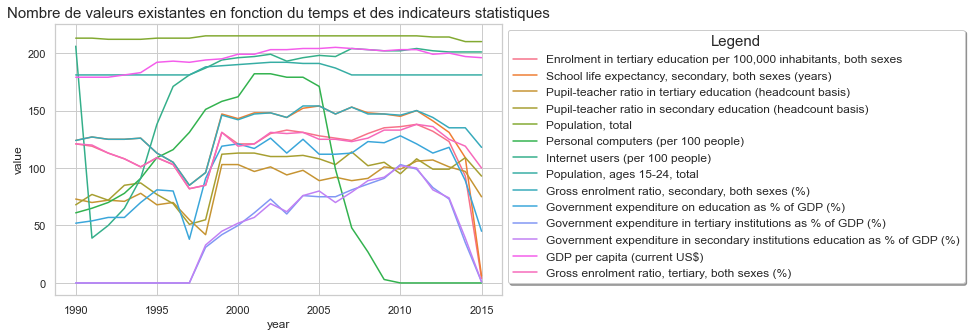

In [100]:
# Visualisation du nombre de valeurs manquantes par colonne pour la table `series`
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))

g = sns.lineplot(
    data=dd, 
    x="year", 
    y="value", 
    hue="indicatorname", 
    legend = True,
    )

g.set_title('Nombre de valeurs existantes en fonction du temps et des indicateurs statistiques', fontsize=15)

g.legend(fontsize = 12, \
       bbox_to_anchor= (1,1), \
       title="Legend", \
       title_fontsize = 15, \
       shadow = True, \
       facecolor = 'white')
#hide_text = g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [65]:
## Les indicateurs finaux qui nous intéressent
listeInd = ['GDP per capita (current US$)', 
            'Government expenditure on education as % of GDP (%)', 
            #'Government expenditure in secondary institutions education as % of GDP (%)',
            #'Government expenditure in tertiary institutions as % of GDP (%)',          
            'Population, ages 15-24, total', 
            #'Population, total',
            #'Personal computers (per 100 people)',#voit sur le graphe que nous ne récupérons plus les données après 2009. Crash boursier ou plus besoin d'avoir un pc pour avoir accès à internet ? 
            #'Enrolment in tertiary education per 100,000 inhabitants, both sexes', #not keeping it because different from the the others
            'Gross enrolment ratio, secondary, both sexes (%)',
            'Gross enrolment ratio, tertiary, both sexes (%)',            
            #'School life expectancy, secondary, both sexes (years)', # Retirre car nous voulons avoir une certaine homogénéité entre nos variables concernant l'éducation
            'Pupil-teacher ratio in secondary education (headcount basis)',
            'Pupil-teacher ratio in tertiary education (headcount basis)', 
            'Internet users (per 100 people)'
           ]

In [66]:
# Modification sur la data2
# Suppression de tous les indicateurs inintéressants
data2 = data2[data2["indicatorname"].isin(listeInd)] 
# Suppression des années en dehors de la période 2000-2013
data2 = data2.astype({"year": int}) 
data2 = data2[(data2.year >=2000) & (data2.year <=2013)].sort_values(by = 'year')
# Suppression des zones géographiques pour ne garder que les pays dans shortname
data2 = data2[data2.countrycode.isin(set(df2.countrycode))];
data2.head()

,countrycode,indicatorname,year,value,country,region,incomegroup
24389462,NGA,Pupil-teacher ratio in secondary education (he...,2000,30.886681,Nigeria,Sub-Saharan Africa,Lower middle income
23864075,ALB,Government expenditure on education as % of GD...,2000,3.287190,Albania,Europe & Central Asia,Upper middle income
23864060,ALB,GDP per capita (current US$),2000,1175.788981,Albania,Europe & Central Asia,Upper middle income
23861703,AFG,Pupil-teacher ratio in tertiary education (hea...,2000,NaN,Afghanistan,South Asia,Low income
23861702,AFG,Pupil-teacher ratio in secondary education (he...,2000,NaN,Afghanistan,South Asia,Low income


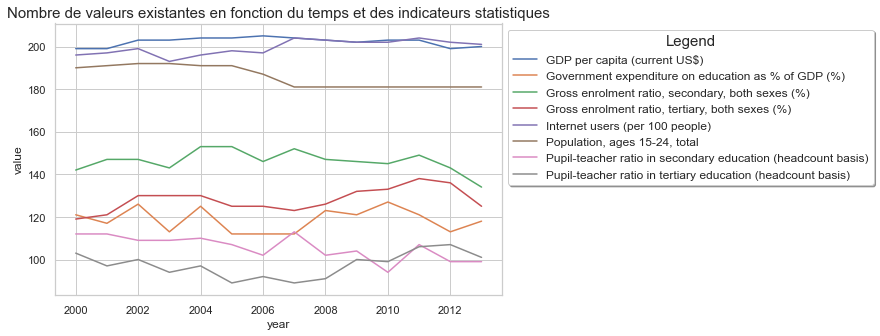

In [101]:
# Visualisation du nombre de valeurs manquantes par colonne pour la table `series`
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))

g = sns.lineplot(
    data= data2.groupby(["year","indicatorname"]).agg({'value': lambda x: x.count()}).sort_values(by = 'year').reset_index(), 
    x="year", 
    y="value", 
    hue="indicatorname", 
    legend = True,
    )

g.set_title('Nombre de valeurs existantes en fonction du temps et des indicateurs statistiques', fontsize=15)

g.legend(fontsize = 12, \
       bbox_to_anchor= (1,1), \
       title="Legend", \
       title_fontsize = 15, \
       shadow = True, \
       facecolor = 'white')
#hide_text = g.set_xticklabels(g.get_xticklabels(), rotation=90)

### Sélection finale des indicateurs statistiques, géographiques et temporels

#### Liste finale des indicateurs statistiques

In [68]:
list_ind = set(data2.indicatorname)
list_ind

{'GDP per capita (current US$)',
 'Government expenditure on education as % of GDP (%)',
 'Gross enrolment ratio, secondary, both sexes (%)',
 'Gross enrolment ratio, tertiary, both sexes (%)',
 'Internet users (per 100 people)',
 'Population, ages 15-24, total',
 'Pupil-teacher ratio in secondary education (headcount basis)',
 'Pupil-teacher ratio in tertiary education (headcount basis)'}

Cette liste contient 8 variables qui peuvent être regroupées en quatre groupes dont un contenant deux sous-groupes. Ces groupes sont: 
    
    - Le groupe qui contient tout ce qui concerne la partie finance. Ce groupe est nommé list_finance :
        - 1. 'GDP per capita (current US$)'
        - 2. 'Government expenditure on education as % of GDP (%)'
    - La variable qui s'intéresse à la possibilité d'avoir accès à internet : 
        - 3. 'Internet users (per 100 people)'
    - La variable qui s'intéresse à la taille du public potentiellement intéressé par notre produit : 
        - 4. 'Population, ages 15-24, total'
    - Le groupe qui contient deux sous-groupes sur l'éducation :
        - Le premier sous-groupe contient les variables liées à l'éducation dans le secondaire:
            - 5. 'Gross enrolment ratio, secondary, both sexes (%)',
            - 6. 'Pupil-teacher ratio in secondary education (headcount basis)',
        - Le deuxième sous-groupe contient les variables liées à l'éducation dans le tertiaire: 
            - 7. 'Gross enrolment ratio, tertiary, both sexes (%)',
            - 8. 'Pupil-teacher ratio in tertiary education (headcount basis)',
        
Nous avons regroupés ces variables de la sorte, de peur que certains groupes ne tirent trop la qualité de l'analyse dans une direction. Comme nous pouvons le constater, nous avons 4 variables qui concernent l'éducation sur les 8. Ce qui signifie qu'elles auront beaucoup plus de poids si nous ne rééquilibrons pas en amont. C'est' pourquoi ces regroupements ont été mis en place. 

#### Liste finale des pays (indicateurs géographiques)

On avait déjà fait un tri auprès des indicateurs géographiques. Mais avec le tri final fait sur les indicateurs temporels, puis sur les indicateurs statistiques, il est intéressant de refaire un tri final sur les indicateurs géographiques avant de passer par l'étape de remplissage des données manquantes. 

In [69]:
print("Il nous reste", data2.country.nunique(), "pays.")

Il nous reste 216 pays.


In [70]:
data2.indicatorname.nunique()*data2.year.nunique()*.5 # On veut au maximum n'avoir que la moitié des valeurs qui manquent pour un pays donné.  
# on voudrait avoir au moins 63 valeurs de données par pays (pas d'analyse fine à ce niveau-là)

56.0

In [71]:
# Deuxième sélection grossière des pays qui nous intéressent
list_cf = data2.groupby('country').count()['value']>=63
list_cf = list(list_cf[list_cf==True].index)
data3 = data2[data2["country"].isin(list_cf)]
data3.country.nunique() # pays restants dans notre jeu de données

165

In [72]:
data3.country.unique()

array(['Nigeria', 'Albania', 'Afghanistan', 'Algeria', 'Angola',
       'Argentina', 'Aruba', 'Armenia', 'Austria', 'Australia',
       'Azerbaijan', 'Bhutan', 'Bahrain', 'Barbados', 'Bangladesh',
       'Benin', 'Belgium', 'Belarus', 'Belize', 'Botswana', 'Bermuda',
       'Bolivia', 'Brazil', 'Congo', 'Brunei', 'Burkina Faso', 'Bulgaria',
       'Cambodia', 'Burundi', 'Cabo Verde', 'Chad', 'Cameroon', 'Canada',
       'Central African Republic', 'Chile', 'China', 'Comoros',
       'Colombia', "Côte d'Ivoire", 'Dem. Rep. Congo', 'Costa Rica',
       'Czech Republic', 'Cyprus', 'Croatia', 'Cuba', 'Denmark', 'Latvia',
       'Iran', 'Ecuador', 'Djibouti', 'Dominican Republic', 'El Salvador',
       'Egypt', 'France', 'Eritrea', 'Estonia', 'Ethiopia', 'Finland',
       'Fiji', 'The Gambia', 'Georgia', 'Ghana', 'Germany', 'Greece',
       'Guatemala', 'Guinea', 'Honduras', 'Guyana', 'Hungary',
       'Hong Kong SAR, China', 'India', 'Iceland', 'Israel', 'Indonesia',
       'Ireland', 'Kor

In [73]:
print("Finalement, il nous reste", data3.country.nunique(), "pays.")

Finalement, il nous reste 165 pays.


In [74]:
set(data2.country[~data2.country.isin(data3.country.unique())])

{'American Samoa',
 'Andorra',
 'Antigua and Barbuda',
 'Bosnia and Herzegovina',
 'Cayman Islands',
 'Channel Islands',
 'Curaçao',
 "Dem. People's Rep. Korea",
 'Dominica',
 'Equatorial Guinea',
 'Faeroe Islands',
 'French Polynesia',
 'Gabon',
 'Gibraltar',
 'Greenland',
 'Grenada',
 'Guam',
 'Guinea-Bissau',
 'Haiti',
 'Iraq',
 'Isle of Man',
 'Kiribati',
 'Kosovo',
 'Liberia',
 'Libya',
 'Liechtenstein',
 'Marshall Islands',
 'Micronesia',
 'Monaco',
 'Montenegro',
 'Nauru',
 'New Caledonia',
 'Northern Mariana Islands',
 'Palau',
 'Papua New Guinea',
 'Puerto Rico',
 'San Marino',
 'Sint Maarten (Dutch part)',
 'Solomon Islands',
 'Somalia',
 'South Sudan',
 'Sri Lanka',
 'St. Martin (French part)',
 'The Bahamas',
 'Trinidad and Tobago',
 'Turkmenistan',
 'Turks and Caicos Islands',
 'Tuvalu',
 'United Arab Emirates',
 'Virgin Islands',
 'Zambia'}

Même si cette méthode retire un certain nombre de pays comme le Turkmenistan, Iraq, Libye, etc., il est préférable de faire cette suppression pour plusieurs raisons. 

Tout d'abord, un certain nombre de 'pays' supprimé sont des îles appartenant à des pays comme Les îles polynésiennes françaises, les îles Saint Martin, Guam etc. Ceci peut aussi englober des contraire des territoires trop petits pour avoir souvent un réel impact économique (pour notre sujet) et ces derniers n'ont pas forcément un système éducatif tertiaire devéloppé (comme Nauru qui doit expatrier ses enfants à l'exterieur de l'île s'ils veulent aller à l'université). 

Il existe aussi certains territoires ayant un système trop repressif pour accepter une quelque forme d'éducation provenant de l'exterieur de leur territoire ou ayant un trop haut niveau de pauvreté pour être capable de répondre à notre demande comme South Sudan, la Corée du Sud ou encore Liberia, etc.

#### Liste finale des années

In [75]:
print(data3.year.nunique());
print(data3.year.unique());

14
[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013]


 La liste finale des années intéressantes pour nous est la période entre 2000 et 2013.

### Remplissage des valeurs manquantes par des valeurs médianes 

In [76]:
# Réorganisation de la data2 pour mieux observées les futures modifications avec le rajout des valeurs là où ils manquent
data3 = data3.sort_values(["indicatorname", "region","incomegroup","country","year", "value"], ascending = (True, True, True, True, True, True))
data3.head()

,countrycode,indicatorname,year,value,country,region,incomegroup
23897045,AUS,GDP per capita (current US$),2000,21690.920999,Australia,East Asia & Pacific,High income: OECD
24692350,AUS,GDP per capita (current US$),2001,19517.841677,Australia,East Asia & Pacific,High income: OECD
25487655,AUS,GDP per capita (current US$),2002,20081.817626,Australia,East Asia & Pacific,High income: OECD
26282960,AUS,GDP per capita (current US$),2003,23465.385586,Australia,East Asia & Pacific,High income: OECD
27078265,AUS,GDP per capita (current US$),2004,30472.379773,Australia,East Asia & Pacific,High income: OECD


In [77]:
# Rajout des valeurs là où ils manquent
data = data3
data['value']= data.groupby(['indicatorname','countrycode'])['value'].transform(lambda x: x.ffill()).transform(lambda x: x.bfill())

# Vérification que l'ajout des valeurs s'est faite correctement
#data[(data.indicatorname == 'Government expenditure on education as % of GDP (%)')].query(isna()).head()

## Analyse exploratoire 

### Analyses univariés et temporelles selon les régions du monde

In [78]:
# Préparation des dataframes qui fournissent les données pour la visualisation 
data2010 = data[data.year ==2010].reset_index()
datat = data.groupby(["region", "year", "indicatorname"]).value.mean().reset_index()

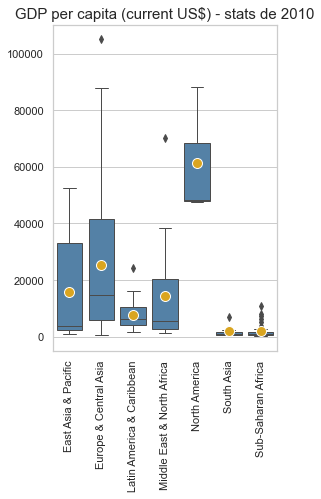

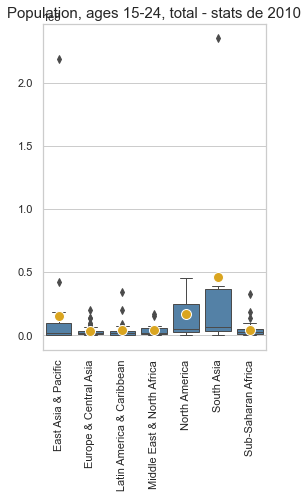

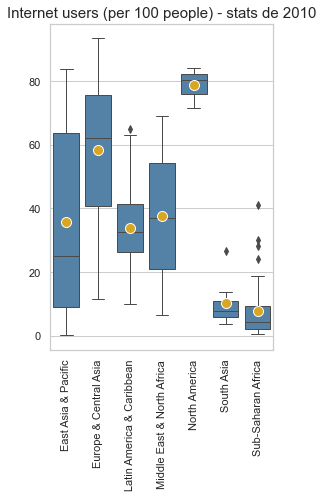

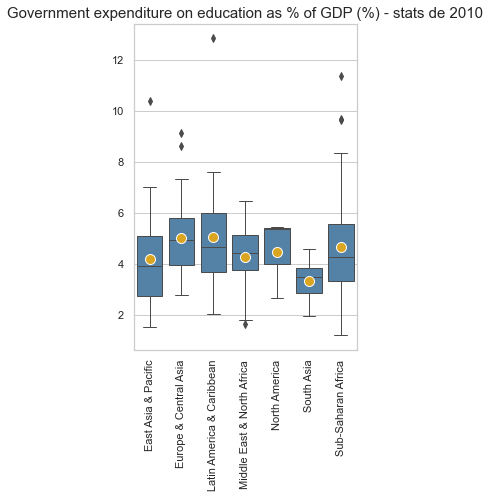

In [79]:
# Visualisation des indicateurs statistiques en fonction de leurs ordres de grandeur - Boxplot
for i in ['GDP per capita (current US$)','Population, ages 15-24, total',
          'Internet users (per 100 people)','Government expenditure on education as % of GDP (%)']:
    fig = plt.figure(1, figsize=(4,6))
    sns.boxplot(data=data2010[data2010.indicatorname==i], 
                y="value", 
                x="region",
                showmeans=True,
                meanprops={"marker":"o",
                           "markerfacecolor":"goldenrod", 
                           "markeredgecolor":"white",
                           "markersize":"10"},
                color = "steelblue",
                linewidth = 1.0, 
               )
    plt.title(i + " - stats de 2010", fontsize =15)
    #plt.ylabel( 
    #    if re.findall(r"\(((.*?)+)\)", i):
    #        print(re.search(r"\(((.*?)+)\)", i).group(1)))
    plt.ylabel("")
    plt.xlabel("")
    plt.xticks(rotation=90)
    plt.show()

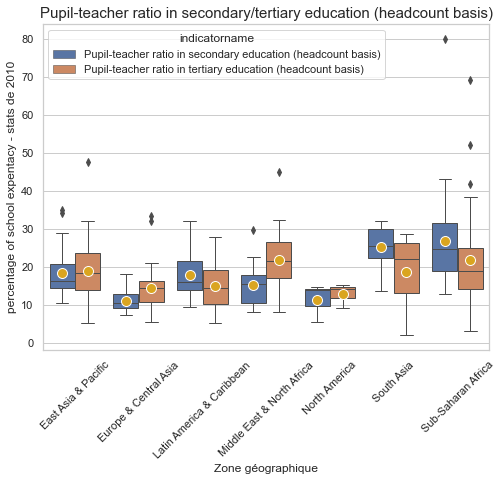

In [80]:
# Visualisation de Pupil-teacher ratio in secondary/tertiary education (headcount basis) par région - Boxplot
fig = plt.figure(1, figsize=(8,6))
sns.boxplot(data=data2010[data2010.indicatorname.isin(['Pupil-teacher ratio in tertiary education (headcount basis)', 'Pupil-teacher ratio in secondary education (headcount basis)'])], 
            y="value", 
            x="region",
            hue="indicatorname",
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"goldenrod", 
                       "markeredgecolor":"white",
                       "markersize":"10"},
            linewidth = 1.0, 
           )
plt.title("Pupil-teacher ratio in secondary/tertiary education (headcount basis)", fontsize =15)
plt.ylabel("percentage of school expentacy - stats de 2010")
plt.xlabel("Zone géographique")
plt.xticks(rotation=45)
plt.show()

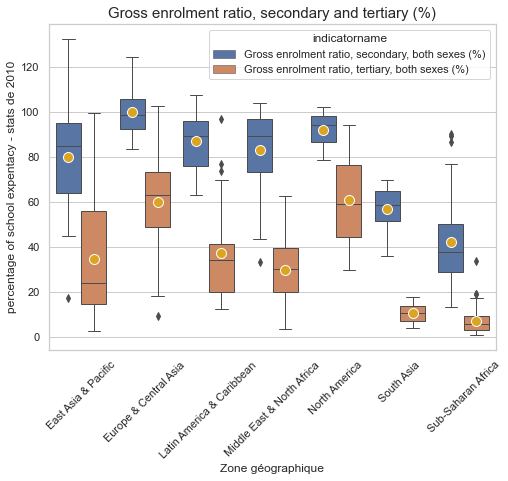

In [81]:
# Visualisation de la Gross enrolment ratio, secondary and tertiary (%) par région - Boxplot
fig = plt.figure(1, figsize=(8,6))
sns.boxplot(data=data2010[data2010.indicatorname.isin(['Gross enrolment ratio, tertiary, both sexes (%)','Gross enrolment ratio, secondary, both sexes (%)'])], 
            y="value", 
            x="region",
            hue="indicatorname", 
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"goldenrod", 
                       "markeredgecolor":"white",
                      "markersize":"10"},
            linewidth = 1.0, 
           )
plt.title("Gross enrolment ratio, secondary and tertiary (%)", fontsize =15)
plt.ylabel("percentage of school expentacy - stats de 2010")
plt.xlabel("Zone géographique")
plt.xticks(rotation=45)
plt.show()

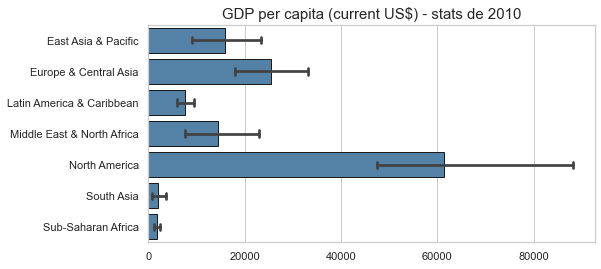

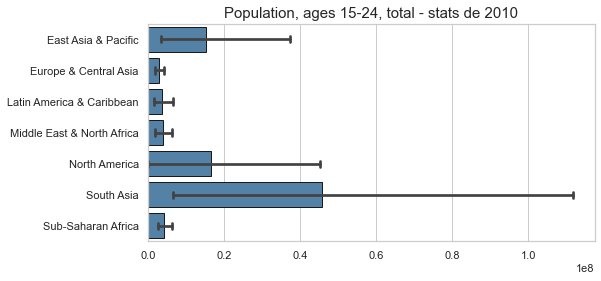

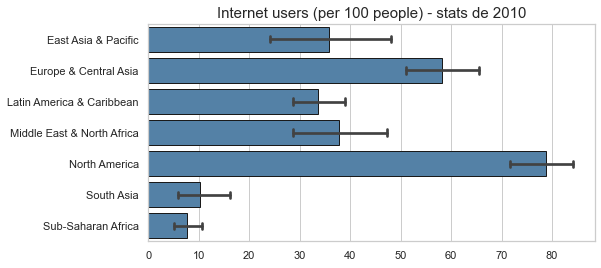

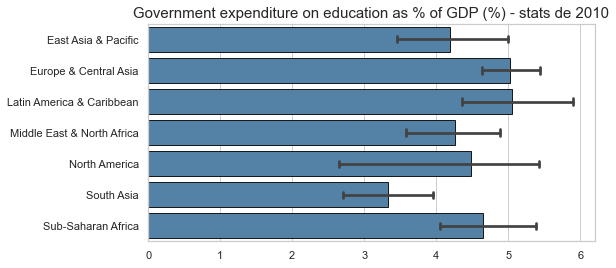

In [82]:
# Visualisation des indicateurs statistiques en fonction de leur volume - Countplot
for i in ['GDP per capita (current US$)','Population, ages 15-24, total',
          'Internet users (per 100 people)','Government expenditure on education as % of GDP (%)']:    
    sns.set_theme(style="whitegrid")
    fig = plt.figure(1, figsize=(8,4))
    ax = sns.barplot(x="value", 
                     y="region", 
                     capsize=.2,
                     data=data2010[data2010.indicatorname==i],
                     color = "steelblue",
                     linewidth = 1.0, 
                     edgecolor=".1"
                    )
    plt.title(i + " - stats de 2010", fontsize =15)
    plt.ylabel("")
    plt.xlabel("")
    plt.show()

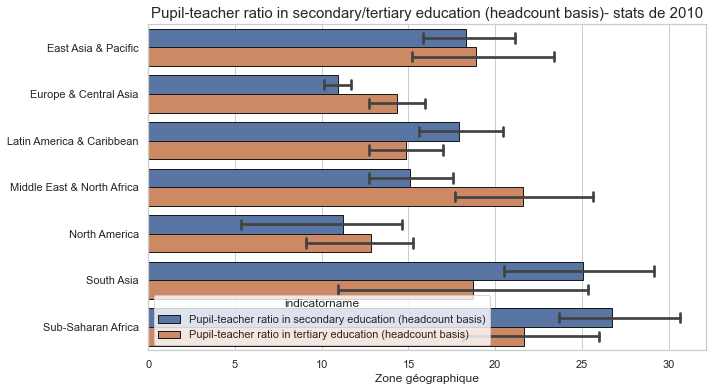

In [83]:
# Visualisation des indicateurs statistiques en fonction de leur volume - Countplot
sns.set_theme(style="whitegrid")
fig = plt.figure(1, figsize=(10,6))
ax = sns.barplot(x="value", 
                 y="region",
                 hue="indicatorname", 
                 capsize=.2,
                 data=data2010[data2010.indicatorname.isin(
                     ['Pupil-teacher ratio in tertiary education (headcount basis)', 
                      'Pupil-teacher ratio in secondary education (headcount basis)'])],
                 linewidth = 1.0, 
                 edgecolor=".1"
                )
plt.title("Pupil-teacher ratio in secondary/tertiary education (headcount basis)- stats de 2010", fontsize = 15)
plt.ylabel("")
plt.xlabel("Zone géographique")
plt.show()

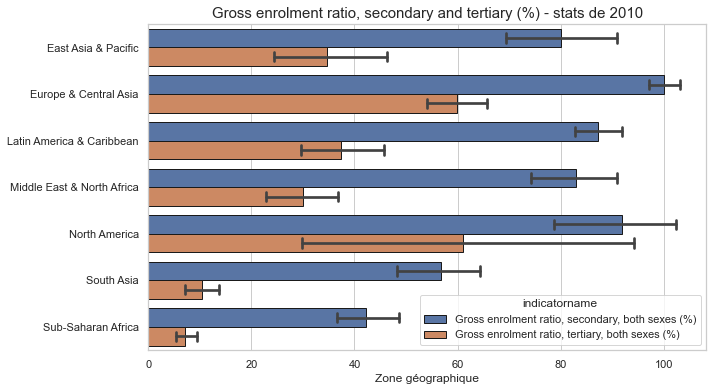

In [84]:
# Visualisation des indicateurs statistiques en fonction de leur volume - Countplot
sns.set_theme(style="whitegrid")
fig = plt.figure(1, figsize=(10,6))
ax = sns.barplot(x="value", 
                 y="region",
                 hue="indicatorname", 
                 capsize=.2,
                 data=data2010[data2010.indicatorname.isin(['Gross enrolment ratio, tertiary, both sexes (%)','Gross enrolment ratio, secondary, both sexes (%)'])],
                 linewidth = 1.0, 
                 edgecolor=".1"
                )
plt.title("Gross enrolment ratio, secondary and tertiary (%) - stats de 2010", fontsize = 15)
plt.ylabel("")
plt.xlabel("Zone géographique")
plt.show()

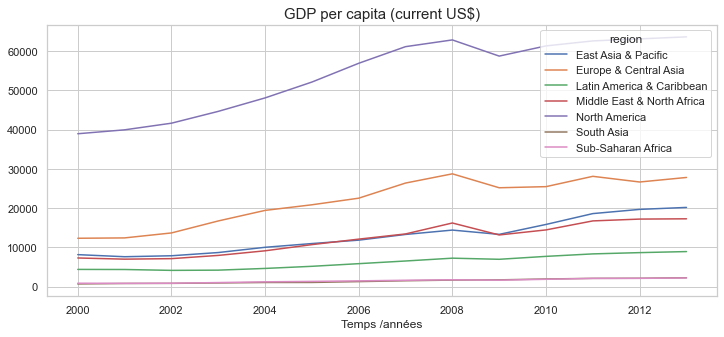

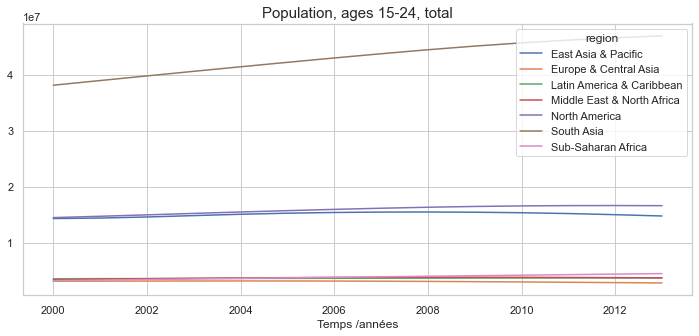

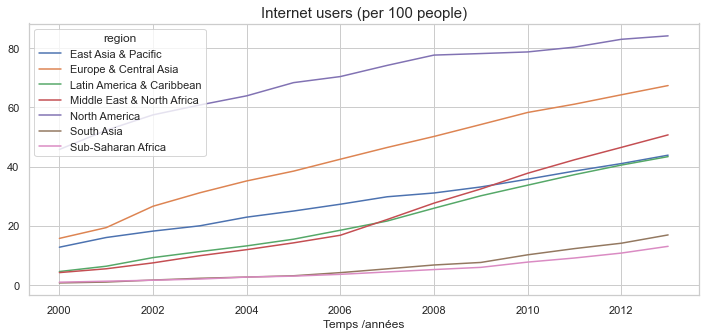

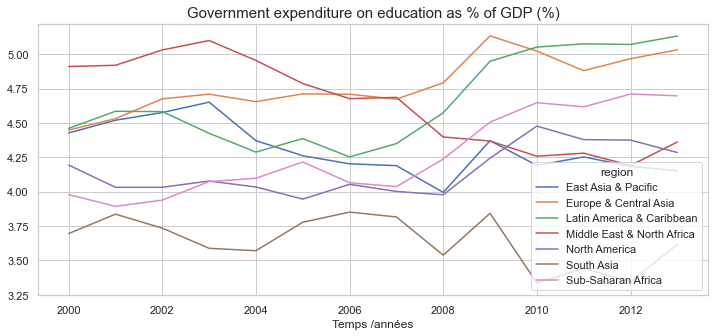

In [85]:
# Visualisation des indicateurs statistiques en fonction du temps - Timeseries
for i in ['GDP per capita (current US$)','Population, ages 15-24, total',
          'Internet users (per 100 people)','Government expenditure on education as % of GDP (%)']: 
    fig = plt.figure(1, figsize=(12,5))
    sns.lineplot(data=datat[datat.indicatorname==i], 
                y= "value", 
                x="year",
                hue="region"
               )
    plt.title(i, fontsize =15)
    plt.ylabel("")
    plt.xlabel("Temps /années")
    plt.show()

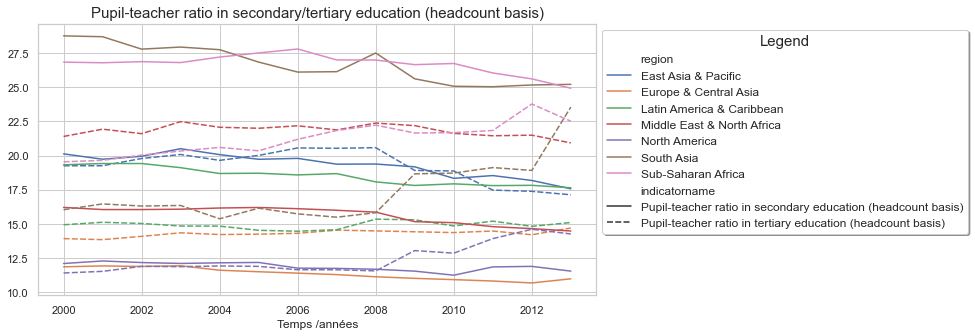

In [86]:
# Visualisation des indicateurs statistiques en fonction du temps - Timeseries
fig = plt.figure(1, figsize=(10,5))
g = sns.lineplot(data=datat[datat.indicatorname.isin(
    ['Pupil-teacher ratio in tertiary education (headcount basis)', 
    'Pupil-teacher ratio in secondary education (headcount basis)'])], 
            y= "value", 
            x="year",
            hue="region",
            style="indicatorname",
            legend = True
           )
g.legend(fontsize = 12, \
       bbox_to_anchor= (1,1), \
       title="Legend", \
       title_fontsize = 15, \
       shadow = True, \
       facecolor = 'white')
plt.title('Pupil-teacher ratio in secondary/tertiary education (headcount basis)', fontsize =15)
plt.ylabel("")
plt.xlabel("Temps /années")
plt.show()

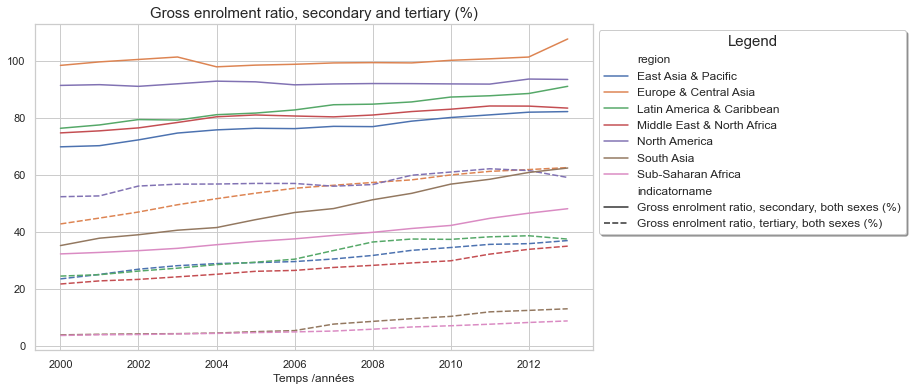

In [87]:
# Visualisation des indicateurs statistiques en fonction du temps - Timeseries
fig = plt.figure(1, figsize=(10,6))
g = sns.lineplot(data=datat[datat.indicatorname.isin(
    ['Gross enrolment ratio, tertiary, both sexes (%)','Gross enrolment ratio, secondary, both sexes (%)'])], 
            y= "value", 
            x="year",
            hue="region",
            style="indicatorname",
            legend = True
           )
g.legend(fontsize = 12, \
       bbox_to_anchor= (1,1), \
       title="Legend", \
       title_fontsize = 15, \
       shadow = True, \
       facecolor = 'white')
plt.title("Gross enrolment ratio, secondary and tertiary (%)", fontsize =15)
plt.ylabel("")
plt.xlabel("Temps /années")
plt.show()

### Analyses univariées et temporelles selon les pays

In [88]:
data2010ch = data2010.sort_values(by=["value"], ascending=False).groupby('indicatorname', sort=False).head(5)
data2010cl = data2010.sort_values(by=["value"], ascending=False).groupby('indicatorname', sort=False).tail(5)
data2010c = pd.concat([data2010ch, data2010cl], ignore_index=True)

datatch = data.sort_values(by=["value"], ascending=False).groupby(["year", "indicatorname"], sort=False).value.mean().reset_index().head(5)
datatcl = data.sort_values(by=["value"], ascending=False).groupby(["country", "year", "indicatorname"], sort=False).value.mean().reset_index().tail(5)
datatc = pd.concat([datatch, datatcl], ignore_index=True)

In [89]:
datatc.country.nunique()

1

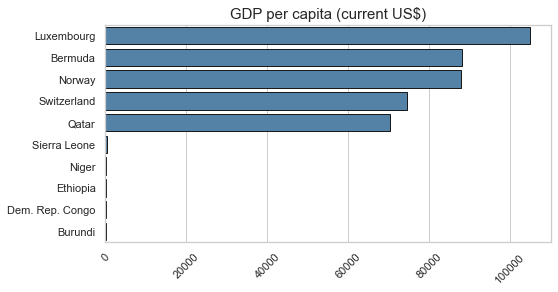

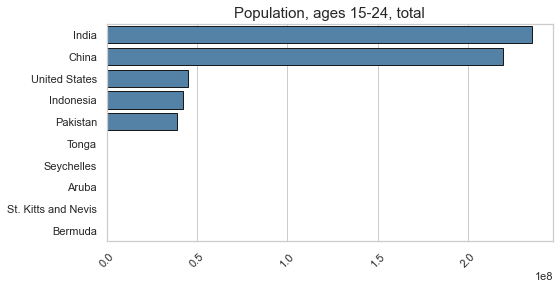

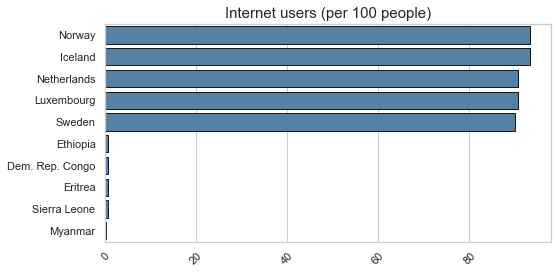

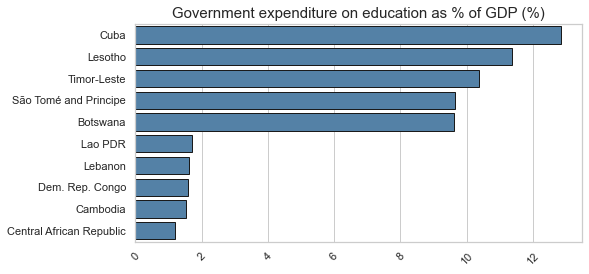

In [90]:
# Visualisation de Pupil-teacher ratio in secondary/tertiary education (headcount basis) par région - Countplot
for i in ['GDP per capita (current US$)','Population, ages 15-24, total',
          'Internet users (per 100 people)','Government expenditure on education as % of GDP (%)']:
    sns.set_theme(style="whitegrid")
    fig = plt.figure(1, figsize=(8,4))
    ax = sns.barplot(x="value", 
                     y="country", 
                     capsize=.2,
                     color="steelblue",
                     data=data2010c[data2010c.indicatorname==i],
                     linewidth = 1.0, 
                     edgecolor=".1"
                    )
    plt.title(i, fontsize =15)
    plt.ylabel("")
    plt.xlabel("")
    plt.xticks(rotation=45)
    plt.show()

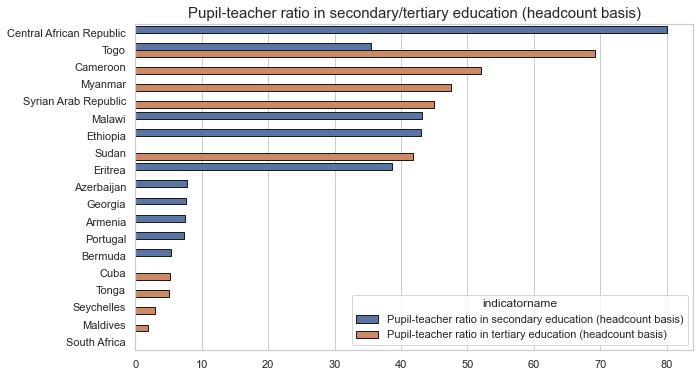

In [91]:
# Visualisation de Pupil-teacher ratio in secondary/tertiary education (headcount basis) par région - Countplot
sns.set_theme(style="whitegrid")
fig = plt.figure(1, figsize=(10,6))
ax = sns.barplot(x="value", 
                 y="country", 
                 hue="indicatorname",
                 capsize=.5,
                 data=data2010c[data2010c.indicatorname.isin([
                     'Pupil-teacher ratio in tertiary education (headcount basis)', 
                     'Pupil-teacher ratio in secondary education (headcount basis)'])],
                 linewidth = 1, 
                 edgecolor=".1"
                )
plt.title('Pupil-teacher ratio in secondary/tertiary education (headcount basis)', fontsize =15)
plt.ylabel("")
plt.xlabel("")
plt.xticks(rotation=0)
plt.show()

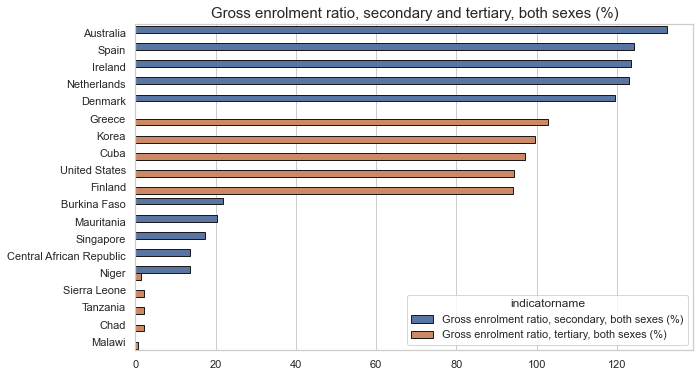

In [92]:
# Visualisation de Pupil-teacher ratio in secondary/tertiary education (headcount basis) par région - Countplot
sns.set_theme(style="whitegrid")
fig = plt.figure(1, figsize=(10,6))
ax = sns.barplot(x="value", 
                 y="country", 
                 hue="indicatorname",
                 capsize=.5,
                 data=data2010c[data2010c.indicatorname.isin([
                     'Gross enrolment ratio, tertiary, both sexes (%)',
                     'Gross enrolment ratio, secondary, both sexes (%)'])],
                 linewidth = 1, 
                 edgecolor=".1"
                )
plt.title( 'Gross enrolment ratio, secondary and tertiary, both sexes (%)', fontsize =15)
plt.ylabel("")
plt.xlabel("")
plt.xticks(rotation=0)
plt.show()

In [93]:
# Création des listes utiles pour faire observer l'évolution temporelle de ces pays
list_pt_ter = set(data2010cl.country[data2010cl.indicatorname == 'Pupil-teacher ratio in tertiary education (headcount basis)'].head(7))
list_pt_sec = set(data2010cl.country[data2010cl.indicatorname == 'Pupil-teacher ratio in secondary education (headcount basis)'].head(7))
list_en_ter = set(data2010ch.country[data2010ch.indicatorname == 'Gross enrolment ratio, tertiary, both sexes (%)'].head(7))
list_en_sec = set(data2010ch.country[data2010ch.indicatorname == 'Gross enrolment ratio, secondary, both sexes (%)'].head(7))

list_pib_h = set(data2010ch.country[data2010ch.indicatorname ==  'GDP per capita (current US$)'].head(7))
list_pop = set(data2010ch.country[data2010ch.indicatorname == 'Population, ages 15-24, total'].head(7))
list_it_h = set(data2010ch.country[data2010ch.indicatorname == 'Internet users (per 100 people)'].head(7))
list_govexp = set(data2010ch.country[data2010ch.indicatorname == 'Government expenditure on education as % of GDP (%)'].head(7))

# update la liste pour pouvoir voir les ordres de grandeurs sur les graphes temporels
list_pt_ter.update(['min', 'max', 'mean', 'median'])
list_pt_sec.update(['min', 'max', 'mean', 'median'])
list_en_ter.update(['min', 'max', 'mean', 'median'])
list_en_sec.update(['min', 'max', 'mean', 'median'])

list_pib_h.update(['min', 'max', 'mean', 'median'])
list_pop.update(['min', 'max', 'mean', 'median'])
list_it_h.update(['min', 'max', 'mean', 'median'])
list_govexp.update(['min', 'max', 'mean', 'median'])

# dictionnaire utile pour le looping
dict_ind = {
    'Pupil-teacher ratio in tertiary education (headcount basis)': list_pt_ter,
    'Pupil-teacher ratio in secondary education (headcount basis)': list_pt_sec,
    'Gross enrolment ratio, tertiary, both sexes (%)': list_en_ter,
    'Gross enrolment ratio, secondary, both sexes (%)': list_en_sec,
    
    'GDP per capita (current US$)': list_pib_h,
    'Population, ages 15-24, total': list_pop,
    'Internet users (per 100 people)': list_it_h,
    'Government expenditure on education as % of GDP (%)': list_govexp
}

In [94]:
# Aggrégation des tables utiles pour les trois séries temporelles du dessous
df_agg = data.groupby(['year', 'indicatorname'])['value'].agg(['min', 'max', 'mean', 'median']).reset_index()
df_agg = df_agg.melt(id_vars=['year', 'indicatorname'], var_name='aggr', value_name ='value')
df_agg['country'] = df_agg['aggr']

datah = data.drop(['countrycode', 'region', 'incomegroup'], axis=1).reset_index()
datah['aggr'] = ''
datah = pd.concat([datah, df_agg], ignore_index=True)

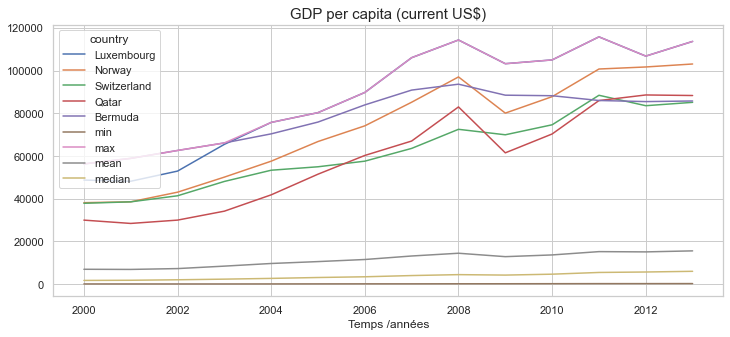

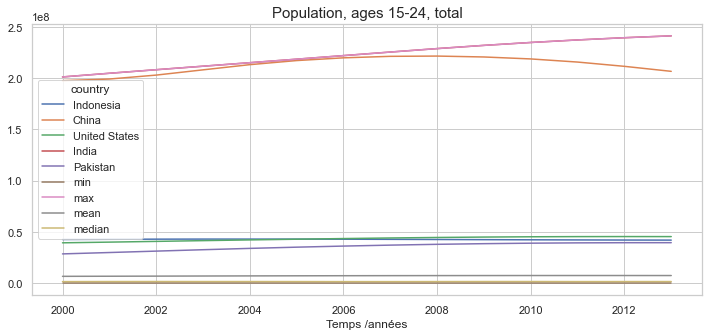

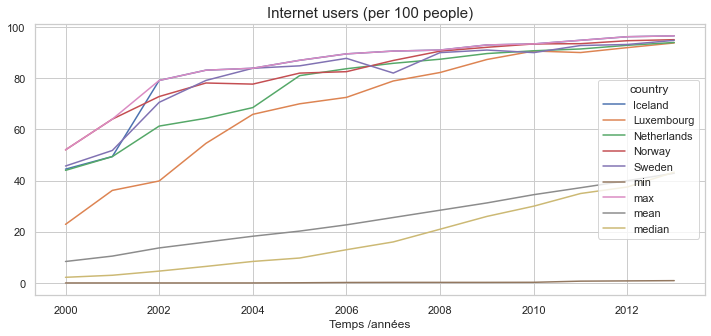

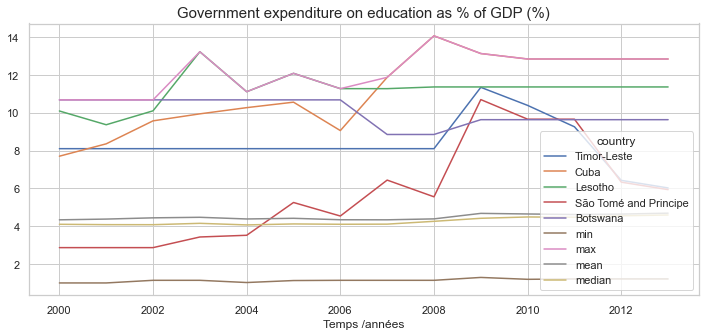

In [102]:
# Visualisation des indicateurs statistiques en fonction du temps - Timeseries
for i in ['GDP per capita (current US$)','Population, ages 15-24, total',
          'Internet users (per 100 people)','Government expenditure on education as % of GDP (%)']:
    fig = plt.figure(1, figsize=(12,5))
    sns.lineplot(data=datah[(datah.indicatorname==i) & (datah.country.isin(dict_ind[i]))], 
                y = "value", 
                x= "year",
                hue= "country",
                legend = True
                )
    g.legend(fontsize = 12, \
           bbox_to_anchor= (1,1), \
           title="Legend", \
           title_fontsize = 15, \
           shadow = True, \
           facecolor = 'white')
    plt.title(i, fontsize =15)
    plt.ylabel("")
    plt.xlabel("Temps /années")
    plt.show()

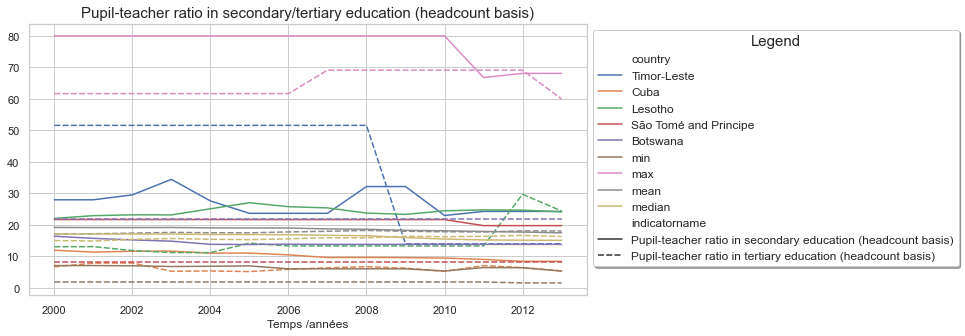

In [96]:
# Visualisation des indicateurs statistiques en fonction du temps - Timeseries
fig = plt.figure(1, figsize=(10,5))
g = sns.lineplot(data=datah[(datah.indicatorname.isin(
    ['Pupil-teacher ratio in tertiary education (headcount basis)', 
    'Pupil-teacher ratio in secondary education (headcount basis)'])) 
    & (datah.country.isin(dict_ind[i]))], 
            y = "value", 
            x= "year",
            hue= "country",
            style ="indicatorname",
            legend = True
            )
g.legend(fontsize = 12, \
       bbox_to_anchor= (1,1), \
       title="Legend", \
       title_fontsize = 15, \
       shadow = True, \
       facecolor = 'white')
plt.title('Pupil-teacher ratio in secondary/tertiary education (headcount basis)', fontsize =15)
plt.ylabel("")
plt.xlabel("Temps /années")
plt.show()

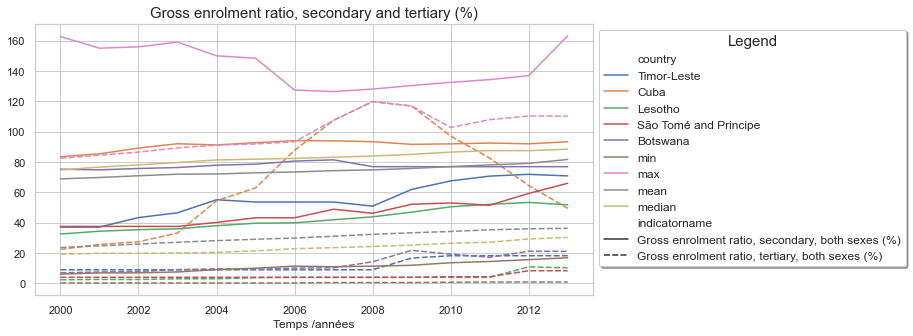

In [97]:
# Visualisation des indicateurs statistiques en fonction du temps - Timeseries
fig = plt.figure(1, figsize=(10,5))
g = sns.lineplot(data=datah[(datah.indicatorname.isin(
    ['Gross enrolment ratio, tertiary, both sexes (%)','Gross enrolment ratio, secondary, both sexes (%)'])) 
    & (datah.country.isin(dict_ind[i]))], 
            y = "value", 
            x= "year",
            hue= "country",
            style ="indicatorname",
            legend = True
            )
g.legend(fontsize = 12, \
       bbox_to_anchor= (1,1), \
       title="Legend", \
       title_fontsize = 15, \
       shadow = True, \
       facecolor = 'white')
plt.title("Gross enrolment ratio, secondary and tertiary (%)", fontsize =15)
plt.ylabel("")
plt.xlabel("Temps /années")
plt.show()